In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import torch
from torch import nn
import torch
import time
import unet
#from IPython.utils import io
#import logging
from pytorch_lightning.callbacks.early_stopping import EarlyStopping
from pytorch_lightning.callbacks import LearningRateMonitor, ModelCheckpoint


import swyft
import pylab as plt
import scipy.stats.distributions as dist
from tqdm import tqdm

torch.set_float32_matmul_precision('medium')
DEVICE = "cuda"

/home/cweniger/.pyenv/versions/3.10.11/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### Generative model

In [3]:
class SimulatorBlob(swyft.Simulator):
    def __init__(self, bounds = None, Npix = 64, sigma = 0.1, bounds_theta = None):
        super().__init__()
        self.transform_samples = swyft.to_numpy32
        self.theta_sampler = swyft.RectBoundSampler([dist.uniform(3.5, 1.00000)], bounds = bounds_theta)
        self.bounds = bounds
        self.Npix = Npix
        self.sigma = sigma
        self.powersampler = swyft.utils.PowerSpectrumSampler(Npix)
        self.sigma = torch.ones(Npix, Npix)*0.1
#        self.sigma[:,:Npix//2] *= 1000

    def get_pk_fn(self, theta):
        return lambda k: 1e6*3*(k/0.5+1)**-theta[0]
        
    def sample_delta(self, pk_fn, use_bounds = True):
        if self.bounds is not None and use_bounds:
            i = np.random.randint(len(self.bounds))
            return torch.tensor(self.bounds[i])
        else:
#            return self.powersampler.sample(lambda k: 1e6*3*(k/0.5)**-theta[0])
            return self.powersampler.sample(pk_fn)

    def psf(self, rho):
        return rho
            
    def build(self, graph):
        theta = graph.node("theta", self.theta_sampler)
        pk_fn = graph.node("pk_fn", self.get_pk_fn, theta)
        delta = graph.node("delta", self.sample_delta, pk_fn)
        delta_unbound = graph.node("delta_unbound", lambda pk_fn: self.sample_delta(pk_fn, use_bounds = False), pk_fn)
        rho = graph.node("rho", lambda delta: torch.exp(delta/5), delta)
        x = graph.node("x", lambda rho: self.psf(rho) + torch.randn(self.Npix, self.Npix)*self.sigma, rho)
#        z = graph.node("test", lambda: lambda x: x)

/home/cweniger/.pyenv/versions/3.10.11/lib/python3.10/site-packages/torch/functional.py:478: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at  ../aten/src/ATen/native/TensorShape.cpp:2894.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


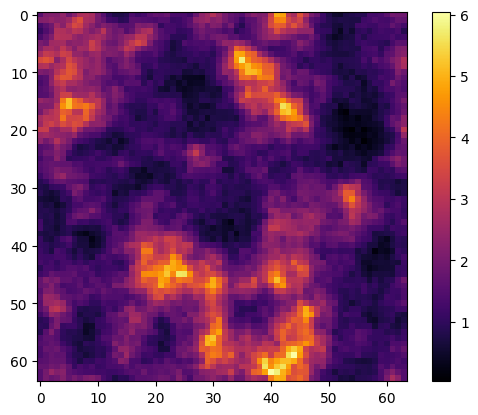

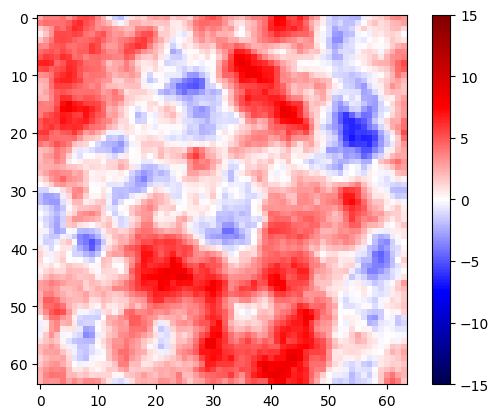

In [4]:
NPIX = 64
sim = SimulatorBlob(Npix = NPIX)
sample0 = sim.sample(conditions = dict(theta = np.array([4.])))
del sample0['pk_fn']
plt.imshow(sample0['x'], cmap = 'inferno')
plt.colorbar()
plt.show()
plt.imshow(sample0['delta'], vmin = -15, vmax = 15, cmap = 'seismic')
plt.colorbar()
plt.show()

### Inference network

In [5]:
class Network(swyft.SwyftModule):
    def __init__(self, lr=1e-3, N = 1024):
        super().__init__()
        self.optimizer_init = swyft.AdamOptimizerInit(lr=1e-4, lrs_factor=0.1, lrs_patience=3)
        self.N = N
        L = lambda x: x*0
        self.Phi = lambda x: x
        self.PhiT = lambda x: x
        self.lre = swyft.LogRatioEstimator_Gaussian_Autoregressive_X_module_based(
            self.N**2, "mu", Phi = self.Phi, PhiT = self.PhiT, L = L, minstd = 1e-5, momentum=0.02)
        self.unet = unet.UNet(1, 1, s = 4)
        self.cnn = torch.nn.Sequential(
            torch.nn.LazyConv2d(8, 3), torch.nn.LazyConv2d(8, 3), torch.nn.ReLU(), torch.nn.MaxPool2d(2), torch.nn.LazyBatchNorm2d(),
            torch.nn.LazyConv2d(16, 3), torch.nn.LazyConv2d(16, 3), torch.nn.ReLU(), torch.nn.MaxPool2d(2), torch.nn.LazyBatchNorm2d(),
            torch.nn.LazyConv2d(32, 3), torch.nn.LazyConv2d(32, 3), torch.nn.ReLU(), torch.nn.MaxPool2d(2), torch.nn.LazyBatchNorm2d(),
            #torch.nn.LazyConv2d(64, 3), torch.nn.LazyConv2d(64, 3), torch.nn.ReLU(), torch.nn.MaxPool2d(2), torch.nn.LazyBatchNorm2d(),
        )
        self.mlp = torch.nn.Sequential(
            torch.nn.LazyLinear(256), torch.nn.ReLU(), torch.nn.LazyBatchNorm1d(),
            torch.nn.LazyLinear(128), torch.nn.ReLU(), torch.nn.LazyBatchNorm1d(),
            torch.nn.LazyLinear(64), torch.nn.ReLU(), torch.nn.LazyBatchNorm1d(),
            torch.nn.LazyLinear(4)
        )
        self.cnn3 = torch.nn.Sequential(
            torch.nn.LazyConv2d(8, 3), torch.nn.LazyConv2d(8, 3), torch.nn.ReLU(), torch.nn.MaxPool2d(2), torch.nn.LazyBatchNorm2d(),
            torch.nn.LazyConv2d(16, 3), torch.nn.LazyConv2d(16, 3), torch.nn.ReLU(), torch.nn.MaxPool2d(2), torch.nn.LazyBatchNorm2d(),
            torch.nn.LazyConv2d(32, 3), torch.nn.LazyConv2d(32, 3), torch.nn.ReLU(), torch.nn.MaxPool2d(2), torch.nn.LazyBatchNorm2d(),
            #torch.nn.LazyConv2d(64, 3), torch.nn.LazyConv2d(64, 3), torch.nn.ReLU(), torch.nn.MaxPool2d(2), torch.nn.LazyBatchNorm2d(),
        )
        self.mlp3 = torch.nn.Sequential(
            torch.nn.LazyLinear(256), torch.nn.ReLU(), torch.nn.LazyBatchNorm1d(),
            torch.nn.LazyLinear(128), torch.nn.ReLU(), torch.nn.LazyBatchNorm1d(),
            torch.nn.LazyLinear(64), torch.nn.ReLU(), torch.nn.LazyBatchNorm1d(),
            torch.nn.LazyLinear(4)
        )

        self.lre2 = swyft.LogRatioEstimator_1dim(4, 1, 'theta:delta')
        self.lre3 = swyft.LogRatioEstimator_1dim(4, 1, 'theta')

        self.norm2b = torch.nn.LazyBatchNorm1d()
        self.norm2a = torch.nn.LazyBatchNorm2d()
        self.norm1 = torch.nn.LazyBatchNorm2d()
        self.norm3 = torch.nn.LazyBatchNorm2d()
    
    def embed(self, x):
        x = self.norm1(x.unsqueeze(1)).squeeze(1)
        x = self.unet(x.unsqueeze(1)).squeeze(1) + x
        x = x.view(-1, self.N**2)
        return x

    def embed2a(self, delta):
        f = self.norm2a(delta)
        f = self.cnn(f.unsqueeze(1)).flatten(start_dim = 1)
        f = self.mlp(f)
        return f

    def embed2b(self, delta):
        f = swyft.utils.ps.get_pk(delta)
        f = self.norm2b(f)
        f = self.mlp(f)
        return f

    def embed3(self, x):
        x = self.norm3(x.unsqueeze(1)).squeeze(1)
        f = self.cnn3(x.unsqueeze(1)).flatten(start_dim = 1)
        f = self.mlp3(f)
        return f

    def forward(self, A, B):
        N = self.N
        try:
            rhoA = self.embed(A['x'])
            rhoB = self.embed(B['x'])
            deltaB = B['delta'].view(-1, N**2)
            result1 = self.lre(rhoA, rhoB, deltaB)
        except KeyError:
            result1 = None

        try:
            f2 = self.embed2b(A['delta_unbound'])
            result2 = self.lre2(f2, B['theta'])
        except KeyError:
            result2 = None

        try:
            f3 = self.embed3(A['x'])
            result3 = self.lre3(f3, B['theta'])
        except KeyError:
            result3 = None
        
        return result1, result2, result3

In [6]:
class Network_delta_x(swyft.SwyftModule):
    def __init__(self, N = 64):
        super().__init__()
        self.optimizer_init = swyft.AdamOptimizerInit(lr=1e-3, lrs_factor=0.1, lrs_patience=3)
        self.N = N
        L = lambda x: x*0
        self.Phi = lambda x: x
        self.PhiT = lambda x: x
        self.lre = swyft.LogRatioEstimator_Gaussian_Autoregressive_X_module_based(
            self.N**2, "mu", Phi = self.Phi, PhiT = self.PhiT, L = L, minstd = 1e-5, momentum=0.02)
        self.unet = unet.UNet(1, 1, s = 4)
        self.norm1 = torch.nn.LazyBatchNorm2d(momentum = 0.01, affine = False)
    
    def embed(self, x):
        # Input normalization apparently degrades performance, even for small momentum settings.
       # x = self.norm1(x.unsqueeze(1)).squeeze(1)
        x = self.unet(x.unsqueeze(1)).squeeze(1) + x
        x = x.view(-1, self.N**2)
        return x

    def forward(self, A, B):
        N = self.N
        try:
            rhoA = self.embed(A['x'])
            rhoB = self.embed(B['x'])
            deltaB = B['delta'].view(-1, N**2)
            result1 = self.lre(rhoA, rhoB, deltaB)
        except KeyError:
            result1 = None
        
        return result1

In [7]:
class Network_theta_x(swyft.SwyftModule):
    def __init__(self):
        super().__init__()
        self.optimizer_init = swyft.AdamOptimizerInit(lr=1e-3, lrs_factor=0.1, lrs_patience=3)
        self.cnn3 = torch.nn.Sequential(
            torch.nn.LazyConv2d(8, 3), torch.nn.LazyConv2d(8, 3), torch.nn.ReLU(), torch.nn.MaxPool2d(2), torch.nn.LazyBatchNorm2d(),
            torch.nn.LazyConv2d(16, 3), torch.nn.LazyConv2d(16, 3), torch.nn.ReLU(), torch.nn.MaxPool2d(2), torch.nn.LazyBatchNorm2d(),
            torch.nn.LazyConv2d(32, 3), torch.nn.LazyConv2d(32, 3), torch.nn.ReLU(), torch.nn.MaxPool2d(2), torch.nn.LazyBatchNorm2d(),
            #torch.nn.LazyConv2d(64, 3), torch.nn.LazyConv2d(64, 3), torch.nn.ReLU(), torch.nn.MaxPool2d(2), torch.nn.LazyBatchNorm2d(),
        )
        self.mlp3 = torch.nn.Sequential(
            torch.nn.LazyLinear(256), torch.nn.ReLU(), torch.nn.LazyBatchNorm1d(),
            torch.nn.LazyLinear(128), torch.nn.ReLU(), torch.nn.LazyBatchNorm1d(),
            torch.nn.LazyLinear(64), torch.nn.ReLU(), torch.nn.LazyBatchNorm1d(),
            torch.nn.LazyLinear(4)
        )
        self.lre3 = swyft.LogRatioEstimator_1dim(4, 1, 'theta', num_blocks = 4, hidden_features = 128)
        self.norm3 = torch.nn.LazyBatchNorm2d(momentum = 0.01)
    
    def embed3(self, x):
        x = self.norm3(x.unsqueeze(1)).squeeze(1)
        f = self.cnn3(x.unsqueeze(1)).flatten(start_dim = 1)
        f = self.mlp3(f)
        return f

    def forward(self, A, B):
        f3 = self.embed3(A['x'])
        result = self.lre3(f3, B['theta'])
        
        return result

### Inference

In [8]:
def get_samples(n_sims = 1000, bounds = None, bounds_theta = None):
    sim = SimulatorBlob(Npix = NPIX, bounds = bounds, bounds_theta = bounds_theta)
    samples = sim.sample(n_sims, exclude = ['pk_fn'])
    return sim, samples

In [9]:
def train_theta_x(samples, max_epochs = 5):
    dm = swyft.SwyftDataModule(samples, fractions = [0.8, 0.1, 0.1], batch_size = 64)
    net = Network_theta_x()
    early_stopping_callback = EarlyStopping(monitor='val_loss', min_delta = 0., patience=10, verbose=True, mode='min')
    checkpoint_callback = ModelCheckpoint(monitor='val_loss', filename='rings_{epoch}_{val_loss:.2f}_{train_loss:.2f}', mode='min')
    trainer = swyft.SwyftTrainer(accelerator = "gpu", devices = [0], max_epochs = max_epochs, precision = 32, callbacks = [checkpoint_callback, early_stopping_callback])
    trainer.fit(net, dm)
    test_loss = trainer.test(net, dm, ckpt_path = 'best')[0]['test_loss']
    return trainer, net, test_loss
    
def infer_theta_x(sample0, sim, trainer, net, test_loss):
    prior_draws = sim.sample(10000, targets = ["theta"], exclude = ['pk_fn'])
    results = trainer.infer(net, sample0, prior_draws)
    swyft.plot_1d(results, 'theta[0]', smooth = 2, bins = 100)
    plt.show()
    bounds = swyft.collect_rect_bounds(results, 'theta', (1,))
    return results, bounds

In [10]:
def train_delta_x(samples, max_epochs = 5):
    dm = swyft.SwyftDataModule(samples, fractions = [0.8, 0.1, 0.1], batch_size = 64)
    net = Network_delta_x()
    #trainer = swyft.SwyftTrainer(accelerator = "gpu", devices = [0], max_epochs = max_epochs, precision = 32)
    early_stopping_callback = EarlyStopping(monitor='val_loss', min_delta = 0., patience=10, verbose=True, mode='min')
    checkpoint_callback = ModelCheckpoint(monitor='val_loss', filename='rongs_{epoch}_{val_loss:.2f}_{train_loss:.2f}', mode='min')
    trainer = swyft.SwyftTrainer(accelerator = "gpu", devices = [0], max_epochs = max_epochs, precision = 32, callbacks = [checkpoint_callback, early_stopping_callback])
    #logging.getLogger("lightning.pytorch.accelerators.cuda").setLevel(logging.ERROR)
    trainer.fit(net, dm)
    test_loss = trainer.test(net, dm, ckpt_path = 'best')[0]['test_loss']
    return trainer, net, test_loss

def infer_delta_x(sample0, sim, trainer, net, test_loss, n_draws = 10, gamma = 0.1):
    GAMMA = gamma
    x = sample0['x']
    d = sample0['delta']
    y = net.cuda().double().embed(torch.tensor(x).cuda().double().unsqueeze(0))[0]
    draws = []
    x0s = []
    for _ in tqdm(range(n_draws)):
        #pk = SimulatorBlob(Npix = NPIX).sample()['pk_fn']
        pk = sim.sample()['pk_fn']
        prior = sim.powersampler.get_prior_Q_factors(pk)
        prior = (prior[0], prior[1].cuda(), prior[2])
        x0 = net.lre.get_MAP(y, prior, gamma = GAMMA)
        x0s.append(x0)
        draw = net.lre.get_noise_samples_GEDA(1, prior, steps = 300, reset = True, gamma = GAMMA)[0]
        draws.append(draw)
    draws = torch.stack(draws)
    x0s = torch.stack(x0s)
    
    bounds = [(x0s[i].view(NPIX, NPIX).cpu().detach() + draws[i].view(NPIX, NPIX).cpu()).numpy() for i in range(len(draws))]
    bounds = np.array(bounds)

    net.float()
    
    v = 15
    plt.figure(figsize = (15, 5))
    for i in range(4):
        plt.subplot(2, 4, i+1)
        if i == 0:
            plt.imshow(sample0['delta'], cmap = 'seismic', vmin = -v, vmax = v)
        else:
            plt.imshow(bounds[i], vmin = -v, vmax = v, cmap = 'seismic')
        plt.colorbar()    
    #res = [(x0.view(NPIX, NPIX).cpu().detach()*0 + draws[i].view(NPIX, NPIX).cpu()).numpy() for i in range(len(draws))]
    print(x.min(), x.max(), bounds[0].min(), bounds[0].max())
    res = [d - bounds[i] for i in range(len(draws))]
    for i in range(4):
        plt.subplot(2, 4, i+1+4)
        plt.imshow(res[i], vmin = -v, vmax = v, cmap = 'seismic')
        plt.colorbar()
    plt.show()

    x = sample0['delta'].flatten()
    y = bounds.reshape(-1, NPIX**2)
    ym = y.mean(axis=0)
    ys = y.std(axis=0)
    plt.scatter(x, ym)
    plt.scatter(x, x)
    plt.show()

    diff = ((y-x)/ys).flatten()
    plt.hist(diff, bins = 100)
    plt.show()
    p = np.percentile(diff, [2.5, 16, 50, 84, 97.5])
    print("Residual percentiles:", p)

    pks = swyft.utils.get_pk(torch.tensor(bounds))
    clean_sims = sim.sample(100)['delta']
    pks2 = swyft.utils.get_pk(torch.tensor(clean_sims))
    pks3 = swyft.utils.get_pk(torch.tensor(sample0['delta']))
    plt.plot([], '0.5', alpha = 0.5, label = "Unconstrained")
    plt.plot([], 'r', alpha = 0.5, label = "Constrained")
    plt.semilogy(pks2.T, '0.5', alpha = 0.5);
    plt.semilogy(pks.T, 'r', alpha = 0.5);
    plt.semilogy(pks3.T, 'y', label = "Truth");
    plt.legend()
    plt.show()  

    return bounds

## The analysis

In [11]:
bounds_theta_x = None
bounds_delta_x = None
bounds_theta_x = torch.tensor([[3.9999, 4.0001]])

### Round 1

100%|█████████████████████████████████████| 3000/3000 [00:02<00:00, 1246.79it/s]
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name  | Type                   | Params
-------------------------------------------------
0 | cnn3  | Sequential             | 0     
1 | mlp3  | Sequential             | 0     
2 | lre3  | LogRatioEstimator_1dim | 135 K 
3 | norm3 | LazyBatchNorm2d        | 0     
-------------------------------------------------
135 K     Trainable params
0         Non-trainable params
135 K     Total params
0.540     Total estimated model params size (MB)


Epoch 0:  88%|█████████▋ | 38/43 [00:01<00:00, 25.45it/s, loss=-0.582, v_num=18]
Validation: 0it [00:00, ?it/s]
Epoch 0:  98%|██████████▋| 42/43 [00:01<00:00, 26.38it/s, loss=-0.582, v_num=18]
Epoch 0: 100%|█| 43/43 [00:01<00:00, 26.58it/s, loss=-0.582, v_num=18, val_loss=
                                                                                

Metric val_loss improved. New best score: 1.198


Epoch 1:  88%|▉| 38/43 [00:01<00:00, 25.42it/s, loss=-0.66, v_num=18, val_loss=1
Validation: 0it [00:00, ?it/s]
Validation DataLoader 0:   0%|                            | 0/5 [00:00<?, ?it/s]
Epoch 1:  91%|▉| 39/43 [00:01<00:00, 25.53it/s, loss=-0.66, v_num=18, val_loss=1
Epoch 1:  93%|▉| 40/43 [00:01<00:00, 25.82it/s, loss=-0.66, v_num=18, val_loss=1
Epoch 1:  95%|▉| 41/43 [00:01<00:00, 26.13it/s, loss=-0.66, v_num=18, val_loss=1
Epoch 1:  98%|▉| 42/43 [00:01<00:00, 26.42it/s, loss=-0.66, v_num=18, val_loss=1
Epoch 1: 100%|█| 43/43 [00:01<00:00, 26.67it/s, loss=-0.66, v_num=18, val_loss=3
Epoch 2:  88%|▉| 38/43 [00:01<00:00, 24.45it/s, loss=-0.71, v_num=18, val_loss=3
Validation: 0it [00:00, ?it/s]
Validation DataLoader 0:   0%|                            | 0/5 [00:00<?, ?it/s]
Epoch 2:  91%|▉| 39/43 [00:01<00:00, 24.41it/s, loss=-0.71, v_num=18, val_loss=3
Epoch 2:  93%|▉| 40/43 [00:01<00:00, 24.70it/s, loss=-0.71, v_num=18, val_loss=3
Epoch 2:  95%|▉| 41/43 [00:01<00:00, 24.98it/s,

Metric val_loss improved by 1.170 >= min_delta = 0.0. New best score: 0.028


Epoch 5:  88%|▉| 38/43 [00:01<00:00, 25.22it/s, loss=-0.835, v_num=18, val_loss=
Validation: 0it [00:00, ?it/s]
Validation DataLoader 0:   0%|                            | 0/5 [00:00<?, ?it/s]
Epoch 5:  91%|▉| 39/43 [00:01<00:00, 25.35it/s, loss=-0.835, v_num=18, val_loss=
Epoch 5:  93%|▉| 40/43 [00:01<00:00, 25.64it/s, loss=-0.835, v_num=18, val_loss=
Epoch 5:  95%|▉| 41/43 [00:01<00:00, 25.98it/s, loss=-0.835, v_num=18, val_loss=
Epoch 5:  98%|▉| 42/43 [00:01<00:00, 26.36it/s, loss=-0.835, v_num=18, val_loss=
Epoch 5: 100%|█| 43/43 [00:01<00:00, 26.69it/s, loss=-0.835, v_num=18, val_loss=
Epoch 6:  88%|▉| 38/43 [00:01<00:00, 27.85it/s, loss=-0.877, v_num=18, val_loss=
Validation: 0it [00:00, ?it/s]
Validation DataLoader 0:   0%|                            | 0/5 [00:00<?, ?it/s]
Epoch 6:  91%|▉| 39/43 [00:01<00:00, 27.81it/s, loss=-0.877, v_num=18, val_loss=
Epoch 6:  93%|▉| 40/43 [00:01<00:00, 28.12it/s, loss=-0.877, v_num=18, val_loss=
Epoch 6:  95%|▉| 41/43 [00:01<00:00, 28.43it/s,

Metric val_loss improved by 0.582 >= min_delta = 0.0. New best score: -0.554


Epoch 7:  88%|▉| 38/43 [00:01<00:00, 24.67it/s, loss=-0.878, v_num=18, val_loss=
Validation: 0it [00:00, ?it/s]
Validation DataLoader 0:   0%|                            | 0/5 [00:00<?, ?it/s]
Epoch 7:  91%|▉| 39/43 [00:01<00:00, 24.83it/s, loss=-0.878, v_num=18, val_loss=
Epoch 7:  93%|▉| 40/43 [00:01<00:00, 25.20it/s, loss=-0.878, v_num=18, val_loss=
Epoch 7:  95%|▉| 41/43 [00:01<00:00, 25.47it/s, loss=-0.878, v_num=18, val_loss=
Epoch 7:  98%|▉| 42/43 [00:01<00:00, 25.81it/s, loss=-0.878, v_num=18, val_loss=
Epoch 7: 100%|█| 43/43 [00:01<00:00, 26.12it/s, loss=-0.878, v_num=18, val_loss=
                                                                                

Metric val_loss improved by 0.217 >= min_delta = 0.0. New best score: -0.771


Epoch 8:  88%|▉| 38/43 [00:01<00:00, 25.50it/s, loss=-0.913, v_num=18, val_loss=
Validation: 0it [00:00, ?it/s]
Validation DataLoader 0:   0%|                            | 0/5 [00:00<?, ?it/s]
Epoch 8:  91%|▉| 39/43 [00:01<00:00, 25.47it/s, loss=-0.913, v_num=18, val_loss=
Epoch 8:  93%|▉| 40/43 [00:01<00:00, 25.80it/s, loss=-0.913, v_num=18, val_loss=
Epoch 8:  95%|▉| 41/43 [00:01<00:00, 26.19it/s, loss=-0.913, v_num=18, val_loss=
Epoch 8:  98%|▉| 42/43 [00:01<00:00, 26.58it/s, loss=-0.913, v_num=18, val_loss=
Epoch 8: 100%|█| 43/43 [00:01<00:00, 26.95it/s, loss=-0.913, v_num=18, val_loss=
Epoch 9:  88%|▉| 38/43 [00:01<00:00, 28.68it/s, loss=-0.95, v_num=18, val_loss=-
Validation: 0it [00:00, ?it/s]
Validation DataLoader 0:   0%|                            | 0/5 [00:00<?, ?it/s]
Epoch 9:  91%|▉| 39/43 [00:01<00:00, 28.68it/s, loss=-0.95, v_num=18, val_loss=-
Epoch 9:  93%|▉| 40/43 [00:01<00:00, 29.03it/s, loss=-0.95, v_num=18, val_loss=-
Epoch 9:  95%|▉| 41/43 [00:01<00:00, 29.42it/s,

Monitored metric val_loss did not improve in the last 10 records. Best score: -0.771. Signaling Trainer to stop.


Epoch 17: 100%|█| 43/43 [00:01<00:00, 28.10it/s, loss=-1.17, v_num=18, val_loss=

Restoring states from the checkpoint path at /home/cweniger/swyft/notebooks/dev/lightning_logs/version_18/checkpoints/rings_epoch=7_val_loss=-0.77_train_loss=-1.00.ckpt


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from checkpoint at /home/cweniger/swyft/notebooks/dev/lightning_logs/version_18/checkpoints/rings_epoch=7_val_loss=-0.77_train_loss=-1.00.ckpt


Testing DataLoader 0: 100%|███████████████████████| 5/5 [00:00<00:00, 67.06it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           -0.8080512285232544
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


100%|██████████████████████████████████| 10000/10000 [00:00<00:00, 10531.18it/s]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████████████| 10/10 [00:00<00:00, 71.81it/s]


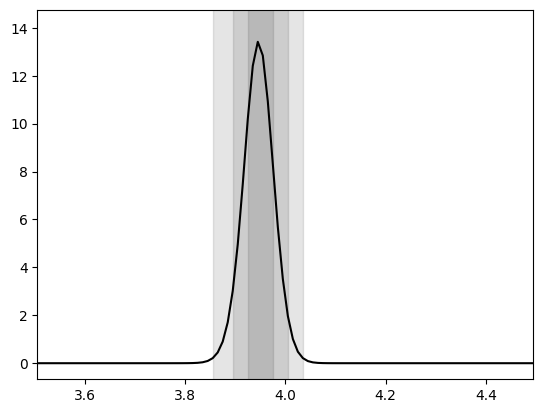

100%|█████████████████████████████████████| 3000/3000 [00:02<00:00, 1393.74it/s]
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name  | Type                   | Params
-------------------------------------------------
0 | cnn3  | Sequential             | 0     
1 | mlp3  | Sequential             | 0     
2 | lre3  | LogRatioEstimator_1dim | 135 K 
3 | norm3 | LazyBatchNorm2d        | 0     
-------------------------------------------------
135 K     Trainable params
0         Non-trainable params
135 K     Total params
0.540     Total estimated model params size (MB)


Epoch 0:  88%|█████████▋ | 38/43 [00:01<00:00, 25.41it/s, loss=-0.481, v_num=19]
Validation: 0it [00:00, ?it/s]
Epoch 0:  98%|██████████▋| 42/43 [00:01<00:00, 26.19it/s, loss=-0.481, v_num=19]
Epoch 0: 100%|█| 43/43 [00:01<00:00, 26.40it/s, loss=-0.481, v_num=19, val_loss=
                                                                                

Metric val_loss improved. New best score: 0.622


Epoch 1:  88%|▉| 38/43 [00:01<00:00, 25.53it/s, loss=-0.592, v_num=19, val_loss=
Validation: 0it [00:00, ?it/s]
Validation DataLoader 0:   0%|                            | 0/5 [00:00<?, ?it/s]
Epoch 1:  91%|▉| 39/43 [00:01<00:00, 25.66it/s, loss=-0.592, v_num=19, val_loss=
Epoch 1:  93%|▉| 40/43 [00:01<00:00, 26.00it/s, loss=-0.592, v_num=19, val_loss=
Epoch 1:  95%|▉| 41/43 [00:01<00:00, 26.28it/s, loss=-0.592, v_num=19, val_loss=
Epoch 1:  98%|▉| 42/43 [00:01<00:00, 26.53it/s, loss=-0.592, v_num=19, val_loss=
Epoch 1: 100%|█| 43/43 [00:01<00:00, 26.68it/s, loss=-0.592, v_num=19, val_loss=
Epoch 2:  88%|▉| 38/43 [00:01<00:00, 27.73it/s, loss=-0.672, v_num=19, val_loss=
Validation: 0it [00:00, ?it/s]
Validation DataLoader 0:   0%|                            | 0/5 [00:00<?, ?it/s]
Epoch 2:  91%|▉| 39/43 [00:01<00:00, 27.63it/s, loss=-0.672, v_num=19, val_loss=
Epoch 2:  93%|▉| 40/43 [00:01<00:00, 27.95it/s, loss=-0.672, v_num=19, val_loss=
Epoch 2:  95%|▉| 41/43 [00:01<00:00, 28.25it/s,

Metric val_loss improved by 1.164 >= min_delta = 0.0. New best score: -0.542


Epoch 6:  88%|▉| 38/43 [00:01<00:00, 27.00it/s, loss=-0.896, v_num=19, val_loss=
Validation: 0it [00:00, ?it/s]
Validation DataLoader 0:   0%|                            | 0/5 [00:00<?, ?it/s]
Epoch 6:  91%|▉| 39/43 [00:01<00:00, 27.04it/s, loss=-0.896, v_num=19, val_loss=
Epoch 6:  93%|▉| 40/43 [00:01<00:00, 27.39it/s, loss=-0.896, v_num=19, val_loss=
Epoch 6:  95%|▉| 41/43 [00:01<00:00, 27.76it/s, loss=-0.896, v_num=19, val_loss=
Epoch 6:  98%|▉| 42/43 [00:01<00:00, 27.99it/s, loss=-0.896, v_num=19, val_loss=
Epoch 6: 100%|█| 43/43 [00:01<00:00, 28.11it/s, loss=-0.896, v_num=19, val_loss=
                                                                                

Metric val_loss improved by 0.029 >= min_delta = 0.0. New best score: -0.571


Epoch 7:  88%|▉| 38/43 [00:01<00:00, 29.29it/s, loss=-0.936, v_num=19, val_loss=
Validation: 0it [00:00, ?it/s]
Validation DataLoader 0:   0%|                            | 0/5 [00:00<?, ?it/s]
Epoch 7:  91%|▉| 39/43 [00:01<00:00, 29.13it/s, loss=-0.936, v_num=19, val_loss=
Epoch 7:  93%|▉| 40/43 [00:01<00:00, 29.44it/s, loss=-0.936, v_num=19, val_loss=
Epoch 7:  95%|▉| 41/43 [00:01<00:00, 29.84it/s, loss=-0.936, v_num=19, val_loss=
Epoch 7:  98%|▉| 42/43 [00:01<00:00, 30.06it/s, loss=-0.936, v_num=19, val_loss=
Epoch 7: 100%|█| 43/43 [00:01<00:00, 30.20it/s, loss=-0.936, v_num=19, val_loss=
                                                                                

Metric val_loss improved by 0.006 >= min_delta = 0.0. New best score: -0.576


Epoch 8:  88%|▉| 38/43 [00:01<00:00, 31.35it/s, loss=-0.97, v_num=19, val_loss=-
Validation: 0it [00:00, ?it/s]
Validation DataLoader 0:   0%|                            | 0/5 [00:00<?, ?it/s]
Epoch 8:  91%|▉| 39/43 [00:01<00:00, 31.42it/s, loss=-0.97, v_num=19, val_loss=-
Epoch 8:  93%|▉| 40/43 [00:01<00:00, 31.83it/s, loss=-0.97, v_num=19, val_loss=-
Epoch 8:  95%|▉| 41/43 [00:01<00:00, 32.12it/s, loss=-0.97, v_num=19, val_loss=-
Epoch 8:  98%|▉| 42/43 [00:01<00:00, 32.48it/s, loss=-0.97, v_num=19, val_loss=-
Epoch 8: 100%|█| 43/43 [00:01<00:00, 32.81it/s, loss=-0.97, v_num=19, val_loss=-
Epoch 9:  88%|▉| 38/43 [00:01<00:00, 25.20it/s, loss=-1, v_num=19, val_loss=-.51
Validation: 0it [00:00, ?it/s]
Validation DataLoader 0:   0%|                            | 0/5 [00:00<?, ?it/s]
Epoch 9:  91%|▉| 39/43 [00:01<00:00, 25.36it/s, loss=-1, v_num=19, val_loss=-.51
Epoch 9:  93%|▉| 40/43 [00:01<00:00, 25.76it/s, loss=-1, v_num=19, val_loss=-.51
Epoch 9:  95%|▉| 41/43 [00:01<00:00, 26.14it/s,

Monitored metric val_loss did not improve in the last 10 records. Best score: -0.576. Signaling Trainer to stop.


Epoch 17: 100%|█| 43/43 [00:01<00:00, 26.28it/s, loss=-1.09, v_num=19, val_loss=


Restoring states from the checkpoint path at /home/cweniger/swyft/notebooks/dev/lightning_logs/version_19/checkpoints/rings_epoch=7_val_loss=-0.58_train_loss=-1.02.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from checkpoint at /home/cweniger/swyft/notebooks/dev/lightning_logs/version_19/checkpoints/rings_epoch=7_val_loss=-0.58_train_loss=-1.02.ckpt


Testing DataLoader 0: 100%|███████████████████████| 5/5 [00:00<00:00, 86.54it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           -0.7467186450958252
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


100%|██████████████████████████████████| 10000/10000 [00:00<00:00, 10668.65it/s]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████████████| 10/10 [00:00<00:00, 68.66it/s]


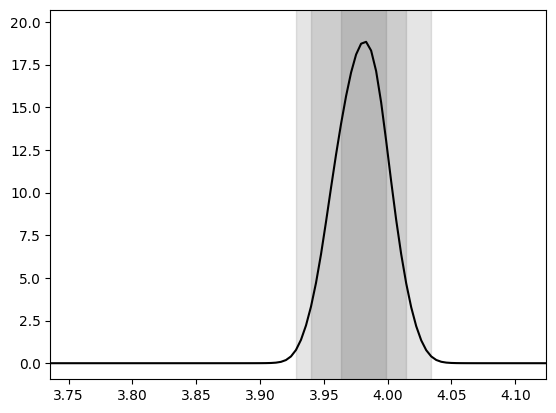

100%|█████████████████████████████████████| 3000/3000 [00:02<00:00, 1407.96it/s]
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name  | Type                   | Params
-------------------------------------------------
0 | cnn3  | Sequential             | 0     
1 | mlp3  | Sequential             | 0     
2 | lre3  | LogRatioEstimator_1dim | 135 K 
3 | norm3 | LazyBatchNorm2d        | 0     
-------------------------------------------------
135 K     Trainable params
0         Non-trainable params
135 K     Total params
0.540     Total estimated model params size (MB)


Epoch 0:  88%|█████████▋ | 38/43 [00:01<00:00, 29.14it/s, loss=-0.375, v_num=20]
Validation: 0it [00:00, ?it/s]
Epoch 0:  98%|██████████▋| 42/43 [00:01<00:00, 29.84it/s, loss=-0.375, v_num=20]
Epoch 0: 100%|█| 43/43 [00:01<00:00, 29.98it/s, loss=-0.375, v_num=20, val_loss=
                                                                                

Metric val_loss improved. New best score: 1.801


Epoch 1:  88%|▉| 38/43 [00:01<00:00, 28.28it/s, loss=-0.516, v_num=20, val_loss=
Validation: 0it [00:00, ?it/s]
Validation DataLoader 0:   0%|                            | 0/5 [00:00<?, ?it/s]
Epoch 1:  91%|▉| 39/43 [00:01<00:00, 28.40it/s, loss=-0.516, v_num=20, val_loss=
Epoch 1:  93%|▉| 40/43 [00:01<00:00, 28.80it/s, loss=-0.516, v_num=20, val_loss=
Epoch 1:  95%|▉| 41/43 [00:01<00:00, 29.24it/s, loss=-0.516, v_num=20, val_loss=
Epoch 1:  98%|▉| 42/43 [00:01<00:00, 29.66it/s, loss=-0.516, v_num=20, val_loss=
Epoch 1: 100%|█| 43/43 [00:01<00:00, 29.85it/s, loss=-0.516, v_num=20, val_loss=
Epoch 2:  88%|▉| 38/43 [00:01<00:00, 29.49it/s, loss=-0.587, v_num=20, val_loss=
Validation: 0it [00:00, ?it/s]
Validation DataLoader 0:   0%|                            | 0/5 [00:00<?, ?it/s]
Epoch 2:  91%|▉| 39/43 [00:01<00:00, 29.53it/s, loss=-0.587, v_num=20, val_loss=
Epoch 2:  93%|▉| 40/43 [00:01<00:00, 29.80it/s, loss=-0.587, v_num=20, val_loss=
Epoch 2:  95%|▉| 41/43 [00:01<00:00, 30.08it/s,

Metric val_loss improved by 0.746 >= min_delta = 0.0. New best score: 1.055


Epoch 6:  88%|▉| 38/43 [00:01<00:00, 27.49it/s, loss=-0.83, v_num=20, val_loss=1
Validation: 0it [00:00, ?it/s]
Validation DataLoader 0:   0%|                            | 0/5 [00:00<?, ?it/s]
Epoch 6:  91%|▉| 39/43 [00:01<00:00, 27.61it/s, loss=-0.83, v_num=20, val_loss=1
Epoch 6:  93%|▉| 40/43 [00:01<00:00, 27.98it/s, loss=-0.83, v_num=20, val_loss=1
Epoch 6:  95%|▉| 41/43 [00:01<00:00, 28.39it/s, loss=-0.83, v_num=20, val_loss=1
Epoch 6:  98%|▉| 42/43 [00:01<00:00, 28.82it/s, loss=-0.83, v_num=20, val_loss=1
Epoch 6: 100%|█| 43/43 [00:01<00:00, 29.17it/s, loss=-0.83, v_num=20, val_loss=0
                                                                                

Metric val_loss improved by 0.864 >= min_delta = 0.0. New best score: 0.191


Epoch 7:  88%|▉| 38/43 [00:01<00:00, 25.47it/s, loss=-0.861, v_num=20, val_loss=
Validation: 0it [00:00, ?it/s]
Validation DataLoader 0:   0%|                            | 0/5 [00:00<?, ?it/s]
Epoch 7:  91%|▉| 39/43 [00:01<00:00, 25.63it/s, loss=-0.861, v_num=20, val_loss=
Epoch 7:  93%|▉| 40/43 [00:01<00:00, 26.01it/s, loss=-0.861, v_num=20, val_loss=
Epoch 7:  95%|▉| 41/43 [00:01<00:00, 26.29it/s, loss=-0.861, v_num=20, val_loss=
Epoch 7:  98%|▉| 42/43 [00:01<00:00, 26.61it/s, loss=-0.861, v_num=20, val_loss=
Epoch 7: 100%|█| 43/43 [00:01<00:00, 26.80it/s, loss=-0.861, v_num=20, val_loss=
                                                                                

Metric val_loss improved by 0.181 >= min_delta = 0.0. New best score: 0.010


Epoch 8:  88%|▉| 38/43 [00:01<00:00, 24.13it/s, loss=-0.897, v_num=20, val_loss=
Validation: 0it [00:00, ?it/s]
Validation DataLoader 0:   0%|                            | 0/5 [00:00<?, ?it/s]
Epoch 8:  91%|▉| 39/43 [00:01<00:00, 24.16it/s, loss=-0.897, v_num=20, val_loss=
Epoch 8:  93%|▉| 40/43 [00:01<00:00, 24.46it/s, loss=-0.897, v_num=20, val_loss=
Epoch 8:  95%|▉| 41/43 [00:01<00:00, 24.82it/s, loss=-0.897, v_num=20, val_loss=
Epoch 8:  98%|▉| 42/43 [00:01<00:00, 25.19it/s, loss=-0.897, v_num=20, val_loss=
Epoch 8: 100%|█| 43/43 [00:01<00:00, 25.53it/s, loss=-0.897, v_num=20, val_loss=
                                                                                

Metric val_loss improved by 0.049 >= min_delta = 0.0. New best score: -0.039


Epoch 9:  88%|▉| 38/43 [00:01<00:00, 26.09it/s, loss=-0.935, v_num=20, val_loss=
Validation: 0it [00:00, ?it/s]
Validation DataLoader 0:   0%|                            | 0/5 [00:00<?, ?it/s]
Epoch 9:  91%|▉| 39/43 [00:01<00:00, 26.11it/s, loss=-0.935, v_num=20, val_loss=
Epoch 9:  93%|▉| 40/43 [00:01<00:00, 26.38it/s, loss=-0.935, v_num=20, val_loss=
Epoch 9:  95%|▉| 41/43 [00:01<00:00, 26.67it/s, loss=-0.935, v_num=20, val_loss=
Epoch 9:  98%|▉| 42/43 [00:01<00:00, 26.92it/s, loss=-0.935, v_num=20, val_loss=
Epoch 9: 100%|█| 43/43 [00:01<00:00, 27.14it/s, loss=-0.935, v_num=20, val_loss=
                                                                                

Metric val_loss improved by 0.138 >= min_delta = 0.0. New best score: -0.177


Epoch 10:  88%|▉| 38/43 [00:01<00:00, 27.00it/s, loss=-0.951, v_num=20, val_loss
Validation: 0it [00:00, ?it/s]
Validation DataLoader 0:   0%|                            | 0/5 [00:00<?, ?it/s]
Epoch 10:  91%|▉| 39/43 [00:01<00:00, 26.95it/s, loss=-0.951, v_num=20, val_loss
Epoch 10:  93%|▉| 40/43 [00:01<00:00, 27.29it/s, loss=-0.951, v_num=20, val_loss
Epoch 10:  95%|▉| 41/43 [00:01<00:00, 27.55it/s, loss=-0.951, v_num=20, val_loss
Epoch 10:  98%|▉| 42/43 [00:01<00:00, 27.81it/s, loss=-0.951, v_num=20, val_loss
Epoch 10: 100%|█| 43/43 [00:01<00:00, 28.06it/s, loss=-0.951, v_num=20, val_loss
Epoch 11:  88%|▉| 38/43 [00:01<00:00, 25.62it/s, loss=-0.956, v_num=20, val_loss
Validation: 0it [00:00, ?it/s]
Validation DataLoader 0:   0%|                            | 0/5 [00:00<?, ?it/s]
Epoch 11:  91%|▉| 39/43 [00:01<00:00, 25.69it/s, loss=-0.956, v_num=20, val_loss
Epoch 11:  93%|▉| 40/43 [00:01<00:00, 25.98it/s, loss=-0.956, v_num=20, val_loss
Epoch 11:  95%|▉| 41/43 [00:01<00:00, 26.34it/s

Metric val_loss improved by 0.195 >= min_delta = 0.0. New best score: -0.372


Epoch 12:  88%|▉| 38/43 [00:01<00:00, 26.09it/s, loss=-0.95, v_num=20, val_loss=
Validation: 0it [00:00, ?it/s]
Validation DataLoader 0:   0%|                            | 0/5 [00:00<?, ?it/s]
Epoch 12:  91%|▉| 39/43 [00:01<00:00, 26.21it/s, loss=-0.95, v_num=20, val_loss=
Epoch 12:  93%|▉| 40/43 [00:01<00:00, 26.50it/s, loss=-0.95, v_num=20, val_loss=
Epoch 12:  95%|▉| 41/43 [00:01<00:00, 26.79it/s, loss=-0.95, v_num=20, val_loss=
Epoch 12:  98%|▉| 42/43 [00:01<00:00, 27.13it/s, loss=-0.95, v_num=20, val_loss=
Epoch 12: 100%|█| 43/43 [00:01<00:00, 27.33it/s, loss=-0.95, v_num=20, val_loss=
Epoch 13:  88%|▉| 38/43 [00:01<00:00, 30.71it/s, loss=-0.963, v_num=20, val_loss
Validation: 0it [00:00, ?it/s]
Validation DataLoader 0:   0%|                            | 0/5 [00:00<?, ?it/s]
Epoch 13:  91%|▉| 39/43 [00:01<00:00, 30.58it/s, loss=-0.963, v_num=20, val_loss
Epoch 13:  93%|▉| 40/43 [00:01<00:00, 30.83it/s, loss=-0.963, v_num=20, val_loss
Epoch 13:  95%|▉| 41/43 [00:01<00:00, 31.05it/s

Monitored metric val_loss did not improve in the last 10 records. Best score: -0.372. Signaling Trainer to stop.


Epoch 21: 100%|█| 43/43 [00:01<00:00, 28.50it/s, loss=-1.06, v_num=20, val_loss=

Restoring states from the checkpoint path at /home/cweniger/swyft/notebooks/dev/lightning_logs/version_20/checkpoints/rings_epoch=11_val_loss=-0.37_train_loss=-1.04.ckpt


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from checkpoint at /home/cweniger/swyft/notebooks/dev/lightning_logs/version_20/checkpoints/rings_epoch=11_val_loss=-0.37_train_loss=-1.04.ckpt


Testing DataLoader 0: 100%|███████████████████████| 5/5 [00:00<00:00, 65.57it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           -0.5515890121459961
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


100%|███████████████████████████████████| 10000/10000 [00:01<00:00, 9877.83it/s]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████████████| 10/10 [00:00<00:00, 95.72it/s]


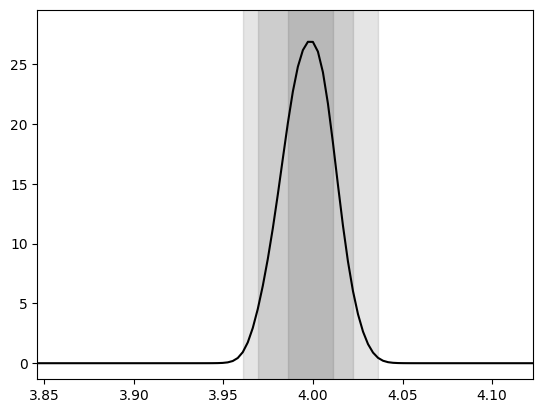

100%|█████████████████████████████████████| 3000/3000 [00:02<00:00, 1423.44it/s]
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name  | Type                   | Params
-------------------------------------------------
0 | cnn3  | Sequential             | 0     
1 | mlp3  | Sequential             | 0     
2 | lre3  | LogRatioEstimator_1dim | 135 K 
3 | norm3 | LazyBatchNorm2d        | 0     
-------------------------------------------------
135 K     Trainable params
0         Non-trainable params
135 K     Total params
0.540     Total estimated model params size (MB)


Epoch 0:  88%|████████▊ | 38/43 [00:01<00:00, 27.77it/s, loss=-0.0581, v_num=21]
Validation: 0it [00:00, ?it/s]
Epoch 0:  98%|█████████▊| 42/43 [00:01<00:00, 29.00it/s, loss=-0.0581, v_num=21]
Epoch 0: 100%|█| 43/43 [00:01<00:00, 29.37it/s, loss=-0.0581, v_num=21, val_loss
                                                                                

Metric val_loss improved. New best score: 0.502


Epoch 1:  88%|▉| 38/43 [00:01<00:00, 29.74it/s, loss=-0.314, v_num=21, val_loss=
Validation: 0it [00:00, ?it/s]
Validation DataLoader 0:   0%|                            | 0/5 [00:00<?, ?it/s]
Epoch 1:  91%|▉| 39/43 [00:01<00:00, 29.64it/s, loss=-0.314, v_num=21, val_loss=
Epoch 1:  93%|▉| 40/43 [00:01<00:00, 29.98it/s, loss=-0.314, v_num=21, val_loss=
Epoch 1:  95%|▉| 41/43 [00:01<00:00, 30.28it/s, loss=-0.314, v_num=21, val_loss=
Epoch 1:  98%|▉| 42/43 [00:01<00:00, 30.54it/s, loss=-0.314, v_num=21, val_loss=
Epoch 1: 100%|█| 43/43 [00:01<00:00, 30.73it/s, loss=-0.314, v_num=21, val_loss=
Epoch 2:  88%|▉| 38/43 [00:01<00:00, 28.14it/s, loss=-0.416, v_num=21, val_loss=
Validation: 0it [00:00, ?it/s]
Validation DataLoader 0:   0%|                            | 0/5 [00:00<?, ?it/s]
Epoch 2:  91%|▉| 39/43 [00:01<00:00, 28.08it/s, loss=-0.416, v_num=21, val_loss=
Epoch 2:  93%|▉| 40/43 [00:01<00:00, 28.43it/s, loss=-0.416, v_num=21, val_loss=
Epoch 2:  95%|▉| 41/43 [00:01<00:00, 28.82it/s,

Metric val_loss improved by 0.069 >= min_delta = 0.0. New best score: 0.433


Epoch 10:  88%|▉| 38/43 [00:01<00:00, 24.40it/s, loss=-0.872, v_num=21, val_loss
Validation: 0it [00:00, ?it/s]
Validation DataLoader 0:   0%|                            | 0/5 [00:00<?, ?it/s]
Epoch 10:  91%|▉| 39/43 [00:01<00:00, 24.37it/s, loss=-0.872, v_num=21, val_loss
Epoch 10:  93%|▉| 40/43 [00:01<00:00, 24.62it/s, loss=-0.872, v_num=21, val_loss
Epoch 10:  95%|▉| 41/43 [00:01<00:00, 24.93it/s, loss=-0.872, v_num=21, val_loss
Epoch 10:  98%|▉| 42/43 [00:01<00:00, 25.28it/s, loss=-0.872, v_num=21, val_loss
Epoch 10: 100%|█| 43/43 [00:01<00:00, 25.52it/s, loss=-0.872, v_num=21, val_loss
                                                                                

Metric val_loss improved by 0.223 >= min_delta = 0.0. New best score: 0.210


Epoch 11:  88%|▉| 38/43 [00:01<00:00, 26.30it/s, loss=-0.878, v_num=21, val_loss
Validation: 0it [00:00, ?it/s]
Validation DataLoader 0:   0%|                            | 0/5 [00:00<?, ?it/s]
Epoch 11:  91%|▉| 39/43 [00:01<00:00, 26.23it/s, loss=-0.878, v_num=21, val_loss
Epoch 11:  93%|▉| 40/43 [00:01<00:00, 26.49it/s, loss=-0.878, v_num=21, val_loss
Epoch 11:  95%|▉| 41/43 [00:01<00:00, 26.82it/s, loss=-0.878, v_num=21, val_loss
Epoch 11:  98%|▉| 42/43 [00:01<00:00, 27.09it/s, loss=-0.878, v_num=21, val_loss
Epoch 11: 100%|█| 43/43 [00:01<00:00, 27.27it/s, loss=-0.878, v_num=21, val_loss
                                                                                

Metric val_loss improved by 0.093 >= min_delta = 0.0. New best score: 0.116


Epoch 12:  88%|▉| 38/43 [00:01<00:00, 26.62it/s, loss=-0.883, v_num=21, val_loss
Validation: 0it [00:00, ?it/s]
Validation DataLoader 0:   0%|                            | 0/5 [00:00<?, ?it/s]
Epoch 12:  91%|▉| 39/43 [00:01<00:00, 26.53it/s, loss=-0.883, v_num=21, val_loss
Epoch 12:  93%|▉| 40/43 [00:01<00:00, 26.80it/s, loss=-0.883, v_num=21, val_loss
Epoch 12:  95%|▉| 41/43 [00:01<00:00, 27.18it/s, loss=-0.883, v_num=21, val_loss
Epoch 12:  98%|▉| 42/43 [00:01<00:00, 27.53it/s, loss=-0.883, v_num=21, val_loss
Epoch 12: 100%|█| 43/43 [00:01<00:00, 27.73it/s, loss=-0.883, v_num=21, val_loss
                                                                                

Metric val_loss improved by 0.083 >= min_delta = 0.0. New best score: 0.034


Epoch 13:  88%|▉| 38/43 [00:01<00:00, 28.40it/s, loss=-0.888, v_num=21, val_loss
Validation: 0it [00:00, ?it/s]
Validation DataLoader 0:   0%|                            | 0/5 [00:00<?, ?it/s]
Epoch 13:  91%|▉| 39/43 [00:01<00:00, 28.27it/s, loss=-0.888, v_num=21, val_loss
Epoch 13:  93%|▉| 40/43 [00:01<00:00, 28.58it/s, loss=-0.888, v_num=21, val_loss
Epoch 13:  95%|▉| 41/43 [00:01<00:00, 28.94it/s, loss=-0.888, v_num=21, val_loss
Epoch 13:  98%|▉| 42/43 [00:01<00:00, 29.31it/s, loss=-0.888, v_num=21, val_loss
Epoch 13: 100%|█| 43/43 [00:01<00:00, 29.64it/s, loss=-0.888, v_num=21, val_loss
                                                                                

Metric val_loss improved by 0.023 >= min_delta = 0.0. New best score: 0.010


Epoch 14:  88%|▉| 38/43 [00:01<00:00, 27.91it/s, loss=-0.895, v_num=21, val_loss
Validation: 0it [00:00, ?it/s]
Validation DataLoader 0:   0%|                            | 0/5 [00:00<?, ?it/s]
Epoch 14:  91%|▉| 39/43 [00:01<00:00, 27.83it/s, loss=-0.895, v_num=21, val_loss
Epoch 14:  93%|▉| 40/43 [00:01<00:00, 28.13it/s, loss=-0.895, v_num=21, val_loss
Epoch 14:  95%|▉| 41/43 [00:01<00:00, 28.41it/s, loss=-0.895, v_num=21, val_loss
Epoch 14:  98%|▉| 42/43 [00:01<00:00, 28.77it/s, loss=-0.895, v_num=21, val_loss
Epoch 14: 100%|█| 43/43 [00:01<00:00, 29.06it/s, loss=-0.895, v_num=21, val_loss
                                                                                

Metric val_loss improved by 0.018 >= min_delta = 0.0. New best score: -0.007


Epoch 15:  88%|▉| 38/43 [00:01<00:00, 26.02it/s, loss=-0.908, v_num=21, val_loss
Validation: 0it [00:00, ?it/s]
Validation DataLoader 0:   0%|                            | 0/5 [00:00<?, ?it/s]
Epoch 15:  91%|▉| 39/43 [00:01<00:00, 25.94it/s, loss=-0.908, v_num=21, val_loss
Epoch 15:  93%|▉| 40/43 [00:01<00:00, 26.22it/s, loss=-0.908, v_num=21, val_loss
Epoch 15:  95%|▉| 41/43 [00:01<00:00, 26.50it/s, loss=-0.908, v_num=21, val_loss
Epoch 15:  98%|▉| 42/43 [00:01<00:00, 26.85it/s, loss=-0.908, v_num=21, val_loss
Epoch 15: 100%|█| 43/43 [00:01<00:00, 27.05it/s, loss=-0.908, v_num=21, val_loss
                                                                                

Metric val_loss improved by 0.013 >= min_delta = 0.0. New best score: -0.020


Epoch 16:  88%|▉| 38/43 [00:01<00:00, 26.56it/s, loss=-0.907, v_num=21, val_loss
Validation: 0it [00:00, ?it/s]
Validation DataLoader 0:   0%|                            | 0/5 [00:00<?, ?it/s]
Epoch 16:  91%|▉| 39/43 [00:01<00:00, 26.66it/s, loss=-0.907, v_num=21, val_loss
Epoch 16:  93%|▉| 40/43 [00:01<00:00, 26.96it/s, loss=-0.907, v_num=21, val_loss
Epoch 16:  95%|▉| 41/43 [00:01<00:00, 27.31it/s, loss=-0.907, v_num=21, val_loss
Epoch 16:  98%|▉| 42/43 [00:01<00:00, 27.67it/s, loss=-0.907, v_num=21, val_loss
Epoch 16: 100%|█| 43/43 [00:01<00:00, 27.87it/s, loss=-0.907, v_num=21, val_loss
Epoch 17:  88%|▉| 38/43 [00:01<00:00, 27.74it/s, loss=-0.916, v_num=21, val_loss
Validation: 0it [00:00, ?it/s]
Validation DataLoader 0:   0%|                            | 0/5 [00:00<?, ?it/s]
Epoch 17:  91%|▉| 39/43 [00:01<00:00, 27.65it/s, loss=-0.916, v_num=21, val_loss
Epoch 17:  93%|▉| 40/43 [00:01<00:00, 27.90it/s, loss=-0.916, v_num=21, val_loss
Epoch 17:  95%|▉| 41/43 [00:01<00:00, 28.16it/s

Monitored metric val_loss did not improve in the last 10 records. Best score: -0.020. Signaling Trainer to stop.


Epoch 25: 100%|█| 43/43 [00:01<00:00, 24.98it/s, loss=-0.934, v_num=21, val_loss


Restoring states from the checkpoint path at /home/cweniger/swyft/notebooks/dev/lightning_logs/version_21/checkpoints/rings_epoch=15_val_loss=-0.02_train_loss=-0.88.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from checkpoint at /home/cweniger/swyft/notebooks/dev/lightning_logs/version_21/checkpoints/rings_epoch=15_val_loss=-0.02_train_loss=-0.88.ckpt


Testing DataLoader 0: 100%|███████████████████████| 5/5 [00:00<00:00, 79.15it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           -0.2685644328594208
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


100%|███████████████████████████████████| 10000/10000 [00:01<00:00, 9649.63it/s]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|█████████████████| 10/10 [00:00<00:00, 141.01it/s]


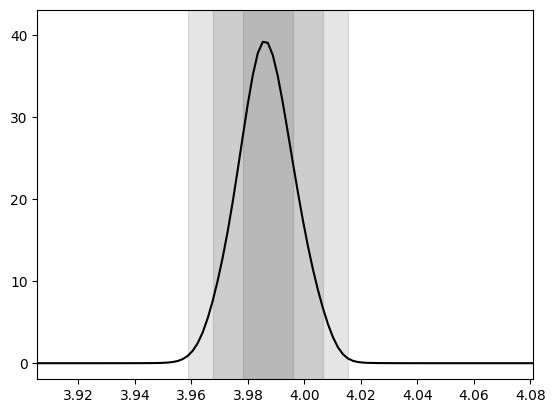

100%|█████████████████████████████████████| 3000/3000 [00:02<00:00, 1374.06it/s]
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name  | Type                   | Params
-------------------------------------------------
0 | cnn3  | Sequential             | 0     
1 | mlp3  | Sequential             | 0     
2 | lre3  | LogRatioEstimator_1dim | 135 K 
3 | norm3 | LazyBatchNorm2d        | 0     
-------------------------------------------------
135 K     Trainable params
0         Non-trainable params
135 K     Total params
0.540     Total estimated model params size (MB)


Epoch 0:  88%|█████████▋ | 38/43 [00:01<00:00, 28.73it/s, loss=-0.227, v_num=22]
Validation: 0it [00:00, ?it/s]
Epoch 0:  98%|██████████▋| 42/43 [00:01<00:00, 29.58it/s, loss=-0.227, v_num=22]
Epoch 0: 100%|█| 43/43 [00:01<00:00, 29.65it/s, loss=-0.227, v_num=22, val_loss=
                                                                                

Metric val_loss improved. New best score: 0.642


Epoch 1:  88%|▉| 38/43 [00:01<00:00, 25.41it/s, loss=-0.348, v_num=22, val_loss=
Validation: 0it [00:00, ?it/s]
Validation DataLoader 0:   0%|                            | 0/5 [00:00<?, ?it/s]
Epoch 1:  91%|▉| 39/43 [00:01<00:00, 25.39it/s, loss=-0.348, v_num=22, val_loss=
Epoch 1:  93%|▉| 40/43 [00:01<00:00, 25.70it/s, loss=-0.348, v_num=22, val_loss=
Epoch 1:  95%|▉| 41/43 [00:01<00:00, 26.04it/s, loss=-0.348, v_num=22, val_loss=
Epoch 1:  98%|▉| 42/43 [00:01<00:00, 26.33it/s, loss=-0.348, v_num=22, val_loss=
Epoch 1: 100%|█| 43/43 [00:01<00:00, 26.53it/s, loss=-0.348, v_num=22, val_loss=
Epoch 2:  88%|▉| 38/43 [00:01<00:00, 26.70it/s, loss=-0.435, v_num=22, val_loss=
Validation: 0it [00:00, ?it/s]
Validation DataLoader 0:   0%|                            | 0/5 [00:00<?, ?it/s]
Epoch 2:  91%|▉| 39/43 [00:01<00:00, 26.70it/s, loss=-0.435, v_num=22, val_loss=
Epoch 2:  93%|▉| 40/43 [00:01<00:00, 27.02it/s, loss=-0.435, v_num=22, val_loss=
Epoch 2:  95%|▉| 41/43 [00:01<00:00, 27.34it/s,

Metric val_loss improved by 0.227 >= min_delta = 0.0. New best score: 0.416


Epoch 11:  88%|▉| 38/43 [00:01<00:00, 27.65it/s, loss=-0.86, v_num=22, val_loss=
Validation: 0it [00:00, ?it/s]
Validation DataLoader 0:   0%|                            | 0/5 [00:00<?, ?it/s]
Epoch 11:  91%|▉| 39/43 [00:01<00:00, 27.64it/s, loss=-0.86, v_num=22, val_loss=
Epoch 11:  93%|▉| 40/43 [00:01<00:00, 27.93it/s, loss=-0.86, v_num=22, val_loss=
Epoch 11:  95%|▉| 41/43 [00:01<00:00, 28.31it/s, loss=-0.86, v_num=22, val_loss=
Epoch 11:  98%|▉| 42/43 [00:01<00:00, 28.70it/s, loss=-0.86, v_num=22, val_loss=
Epoch 11: 100%|█| 43/43 [00:01<00:00, 28.96it/s, loss=-0.86, v_num=22, val_loss=
                                                                                

Metric val_loss improved by 0.082 >= min_delta = 0.0. New best score: 0.333


Epoch 12:  88%|▉| 38/43 [00:01<00:00, 28.55it/s, loss=-0.865, v_num=22, val_loss
Validation: 0it [00:00, ?it/s]
Validation DataLoader 0:   0%|                            | 0/5 [00:00<?, ?it/s]
Epoch 12:  91%|▉| 39/43 [00:01<00:00, 28.56it/s, loss=-0.865, v_num=22, val_loss
Epoch 12:  93%|▉| 40/43 [00:01<00:00, 28.82it/s, loss=-0.865, v_num=22, val_loss
Epoch 12:  95%|▉| 41/43 [00:01<00:00, 29.13it/s, loss=-0.865, v_num=22, val_loss
Epoch 12:  98%|▉| 42/43 [00:01<00:00, 29.41it/s, loss=-0.865, v_num=22, val_loss
Epoch 12: 100%|█| 43/43 [00:01<00:00, 29.67it/s, loss=-0.865, v_num=22, val_loss
                                                                                

Metric val_loss improved by 0.053 >= min_delta = 0.0. New best score: 0.281


Epoch 13:  88%|▉| 38/43 [00:01<00:00, 27.71it/s, loss=-0.87, v_num=22, val_loss=
Validation: 0it [00:00, ?it/s]
Validation DataLoader 0:   0%|                            | 0/5 [00:00<?, ?it/s]
Epoch 13:  91%|▉| 39/43 [00:01<00:00, 27.62it/s, loss=-0.87, v_num=22, val_loss=
Epoch 13:  93%|▉| 40/43 [00:01<00:00, 27.91it/s, loss=-0.87, v_num=22, val_loss=
Epoch 13:  95%|▉| 41/43 [00:01<00:00, 28.22it/s, loss=-0.87, v_num=22, val_loss=
Epoch 13:  98%|▉| 42/43 [00:01<00:00, 28.53it/s, loss=-0.87, v_num=22, val_loss=
Epoch 13: 100%|█| 43/43 [00:01<00:00, 28.69it/s, loss=-0.87, v_num=22, val_loss=
                                                                                

Metric val_loss improved by 0.056 >= min_delta = 0.0. New best score: 0.224


Epoch 14:  88%|▉| 38/43 [00:01<00:00, 25.20it/s, loss=-0.881, v_num=22, val_loss
Validation: 0it [00:00, ?it/s]
Validation DataLoader 0:   0%|                            | 0/5 [00:00<?, ?it/s]
Epoch 14:  91%|▉| 39/43 [00:01<00:00, 25.27it/s, loss=-0.881, v_num=22, val_loss
Epoch 14:  93%|▉| 40/43 [00:01<00:00, 25.55it/s, loss=-0.881, v_num=22, val_loss
Epoch 14:  95%|▉| 41/43 [00:01<00:00, 25.85it/s, loss=-0.881, v_num=22, val_loss
Epoch 14:  98%|▉| 42/43 [00:01<00:00, 26.13it/s, loss=-0.881, v_num=22, val_loss
Epoch 14: 100%|█| 43/43 [00:01<00:00, 26.42it/s, loss=-0.881, v_num=22, val_loss
                                                                                

Metric val_loss improved by 0.004 >= min_delta = 0.0. New best score: 0.220


Epoch 15:  88%|▉| 38/43 [00:01<00:00, 27.49it/s, loss=-0.882, v_num=22, val_loss
Validation: 0it [00:00, ?it/s]
Validation DataLoader 0:   0%|                            | 0/5 [00:00<?, ?it/s]
Epoch 15:  91%|▉| 39/43 [00:01<00:00, 27.44it/s, loss=-0.882, v_num=22, val_loss
Epoch 15:  93%|▉| 40/43 [00:01<00:00, 27.76it/s, loss=-0.882, v_num=22, val_loss
Epoch 15:  95%|▉| 41/43 [00:01<00:00, 28.03it/s, loss=-0.882, v_num=22, val_loss
Epoch 15:  98%|▉| 42/43 [00:01<00:00, 28.28it/s, loss=-0.882, v_num=22, val_loss
Epoch 15: 100%|█| 43/43 [00:01<00:00, 28.48it/s, loss=-0.882, v_num=22, val_loss
                                                                                

Metric val_loss improved by 0.018 >= min_delta = 0.0. New best score: 0.203


Epoch 16:  88%|▉| 38/43 [00:01<00:00, 27.06it/s, loss=-0.89, v_num=22, val_loss=
Validation: 0it [00:00, ?it/s]
Validation DataLoader 0:   0%|                            | 0/5 [00:00<?, ?it/s]
Epoch 16:  91%|▉| 39/43 [00:01<00:00, 27.21it/s, loss=-0.89, v_num=22, val_loss=
Epoch 16:  93%|▉| 40/43 [00:01<00:00, 27.50it/s, loss=-0.89, v_num=22, val_loss=
Epoch 16:  95%|▉| 41/43 [00:01<00:00, 27.79it/s, loss=-0.89, v_num=22, val_loss=
Epoch 16:  98%|▉| 42/43 [00:01<00:00, 28.04it/s, loss=-0.89, v_num=22, val_loss=
Epoch 16: 100%|█| 43/43 [00:01<00:00, 28.23it/s, loss=-0.89, v_num=22, val_loss=
Epoch 17:  88%|▉| 38/43 [00:01<00:00, 25.46it/s, loss=-0.901, v_num=22, val_loss
Validation: 0it [00:00, ?it/s]
Validation DataLoader 0:   0%|                            | 0/5 [00:00<?, ?it/s]
Epoch 17:  91%|▉| 39/43 [00:01<00:00, 25.51it/s, loss=-0.901, v_num=22, val_loss
Epoch 17:  93%|▉| 40/43 [00:01<00:00, 25.84it/s, loss=-0.901, v_num=22, val_loss
Epoch 17:  95%|▉| 41/43 [00:01<00:00, 26.21it/s

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.203


Epoch 22:  88%|▉| 38/43 [00:01<00:00, 27.79it/s, loss=-0.914, v_num=22, val_loss
Validation: 0it [00:00, ?it/s]
Validation DataLoader 0:   0%|                            | 0/5 [00:00<?, ?it/s]
Epoch 22:  91%|▉| 39/43 [00:01<00:00, 27.86it/s, loss=-0.914, v_num=22, val_loss
Epoch 22:  93%|▉| 40/43 [00:01<00:00, 28.18it/s, loss=-0.914, v_num=22, val_loss
Epoch 22:  95%|▉| 41/43 [00:01<00:00, 28.47it/s, loss=-0.914, v_num=22, val_loss
Epoch 22:  98%|▉| 42/43 [00:01<00:00, 28.75it/s, loss=-0.914, v_num=22, val_loss
Epoch 22: 100%|█| 43/43 [00:01<00:00, 28.96it/s, loss=-0.914, v_num=22, val_loss
Epoch 23:  88%|▉| 38/43 [00:01<00:00, 25.82it/s, loss=-0.912, v_num=22, val_loss
Validation: 0it [00:00, ?it/s]
Validation DataLoader 0:   0%|                            | 0/5 [00:00<?, ?it/s]
Epoch 23:  91%|▉| 39/43 [00:01<00:00, 25.98it/s, loss=-0.912, v_num=22, val_loss
Epoch 23:  93%|▉| 40/43 [00:01<00:00, 26.36it/s, loss=-0.912, v_num=22, val_loss
Epoch 23:  95%|▉| 41/43 [00:01<00:00, 26.63it/s

Metric val_loss improved by 0.001 >= min_delta = 0.0. New best score: 0.202


Epoch 24:  88%|▉| 38/43 [00:01<00:00, 26.40it/s, loss=-0.918, v_num=22, val_loss
Validation: 0it [00:00, ?it/s]
Validation DataLoader 0:   0%|                            | 0/5 [00:00<?, ?it/s]
Epoch 24:  91%|▉| 39/43 [00:01<00:00, 26.46it/s, loss=-0.918, v_num=22, val_loss
Epoch 24:  93%|▉| 40/43 [00:01<00:00, 26.73it/s, loss=-0.918, v_num=22, val_loss
Epoch 24:  95%|▉| 41/43 [00:01<00:00, 27.01it/s, loss=-0.918, v_num=22, val_loss
Epoch 24:  98%|▉| 42/43 [00:01<00:00, 27.27it/s, loss=-0.918, v_num=22, val_loss
Epoch 24: 100%|█| 43/43 [00:01<00:00, 27.42it/s, loss=-0.918, v_num=22, val_loss
Epoch 25:  88%|▉| 38/43 [00:01<00:00, 28.31it/s, loss=-0.912, v_num=22, val_loss
Validation: 0it [00:00, ?it/s]
Validation DataLoader 0:   0%|                            | 0/5 [00:00<?, ?it/s]
Epoch 25:  91%|▉| 39/43 [00:01<00:00, 28.30it/s, loss=-0.912, v_num=22, val_loss
Epoch 25:  93%|▉| 40/43 [00:01<00:00, 28.55it/s, loss=-0.912, v_num=22, val_loss
Epoch 25:  95%|▉| 41/43 [00:01<00:00, 28.79it/s

Monitored metric val_loss did not improve in the last 10 records. Best score: 0.202. Signaling Trainer to stop.


Epoch 33: 100%|█| 43/43 [00:01<00:00, 29.41it/s, loss=-0.913, v_num=22, val_loss

Restoring states from the checkpoint path at /home/cweniger/swyft/notebooks/dev/lightning_logs/version_22/checkpoints/rings_epoch=23_val_loss=0.20_train_loss=-0.91.ckpt


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from checkpoint at /home/cweniger/swyft/notebooks/dev/lightning_logs/version_22/checkpoints/rings_epoch=23_val_loss=0.20_train_loss=-0.91.ckpt


Testing DataLoader 0: 100%|██████████████████████| 5/5 [00:00<00:00, 110.86it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           -0.3715304434299469
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


100%|███████████████████████████████████| 10000/10000 [00:01<00:00, 9497.36it/s]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████████████| 10/10 [00:00<00:00, 99.89it/s]


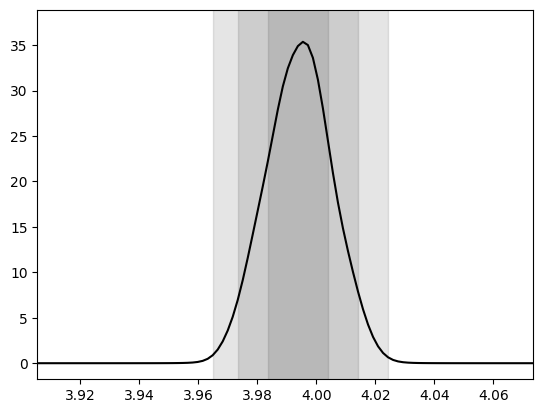

100%|█████████████████████████████████████| 3000/3000 [00:02<00:00, 1416.14it/s]
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name  | Type                   | Params
-------------------------------------------------
0 | cnn3  | Sequential             | 0     
1 | mlp3  | Sequential             | 0     
2 | lre3  | LogRatioEstimator_1dim | 135 K 
3 | norm3 | LazyBatchNorm2d        | 0     
-------------------------------------------------
135 K     Trainable params
0         Non-trainable params
135 K     Total params
0.540     Total estimated model params size (MB)


Epoch 0:  88%|█████████▋ | 38/43 [00:01<00:00, 28.08it/s, loss=-0.185, v_num=23]
Validation: 0it [00:00, ?it/s]
Epoch 0:  98%|██████████▋| 42/43 [00:01<00:00, 29.05it/s, loss=-0.185, v_num=23]
Epoch 0: 100%|█| 43/43 [00:01<00:00, 29.21it/s, loss=-0.185, v_num=23, val_loss=
                                                                                

Metric val_loss improved. New best score: 0.228


Epoch 1:  88%|▉| 38/43 [00:01<00:00, 24.75it/s, loss=-0.267, v_num=23, val_loss=
Validation: 0it [00:00, ?it/s]
Validation DataLoader 0:   0%|                            | 0/5 [00:00<?, ?it/s]
Epoch 1:  91%|▉| 39/43 [00:01<00:00, 24.84it/s, loss=-0.267, v_num=23, val_loss=
Epoch 1:  93%|▉| 40/43 [00:01<00:00, 25.11it/s, loss=-0.267, v_num=23, val_loss=
Epoch 1:  95%|▉| 41/43 [00:01<00:00, 25.46it/s, loss=-0.267, v_num=23, val_loss=
Epoch 1:  98%|▉| 42/43 [00:01<00:00, 25.71it/s, loss=-0.267, v_num=23, val_loss=
Epoch 1: 100%|█| 43/43 [00:01<00:00, 25.97it/s, loss=-0.267, v_num=23, val_loss=
                                                                                

Metric val_loss improved by 0.074 >= min_delta = 0.0. New best score: 0.154


Epoch 2:  88%|▉| 38/43 [00:01<00:00, 26.42it/s, loss=-0.376, v_num=23, val_loss=
Validation: 0it [00:00, ?it/s]
Validation DataLoader 0:   0%|                            | 0/5 [00:00<?, ?it/s]
Epoch 2:  91%|▉| 39/43 [00:01<00:00, 26.55it/s, loss=-0.376, v_num=23, val_loss=
Epoch 2:  93%|▉| 40/43 [00:01<00:00, 26.86it/s, loss=-0.376, v_num=23, val_loss=
Epoch 2:  95%|▉| 41/43 [00:01<00:00, 27.19it/s, loss=-0.376, v_num=23, val_loss=
Epoch 2:  98%|▉| 42/43 [00:01<00:00, 27.47it/s, loss=-0.376, v_num=23, val_loss=
Epoch 2: 100%|█| 43/43 [00:01<00:00, 27.67it/s, loss=-0.376, v_num=23, val_loss=
Epoch 3:  88%|▉| 38/43 [00:01<00:00, 28.62it/s, loss=-0.455, v_num=23, val_loss=
Validation: 0it [00:00, ?it/s]
Validation DataLoader 0:   0%|                            | 0/5 [00:00<?, ?it/s]
Epoch 3:  91%|▉| 39/43 [00:01<00:00, 28.61it/s, loss=-0.455, v_num=23, val_loss=
Epoch 3:  93%|▉| 40/43 [00:01<00:00, 28.77it/s, loss=-0.455, v_num=23, val_loss=
Epoch 3:  95%|▉| 41/43 [00:01<00:00, 28.89it/s,

Metric val_loss improved by 0.010 >= min_delta = 0.0. New best score: 0.143


Epoch 11:  88%|▉| 38/43 [00:01<00:00, 28.07it/s, loss=-0.839, v_num=23, val_loss
Validation: 0it [00:00, ?it/s]
Validation DataLoader 0:   0%|                            | 0/5 [00:00<?, ?it/s]
Epoch 11:  91%|▉| 39/43 [00:01<00:00, 28.19it/s, loss=-0.839, v_num=23, val_loss
Epoch 11:  93%|▉| 40/43 [00:01<00:00, 28.59it/s, loss=-0.839, v_num=23, val_loss
Epoch 11:  95%|▉| 41/43 [00:01<00:00, 28.99it/s, loss=-0.839, v_num=23, val_loss
Epoch 11:  98%|▉| 42/43 [00:01<00:00, 29.42it/s, loss=-0.839, v_num=23, val_loss
Epoch 11: 100%|█| 43/43 [00:01<00:00, 29.77it/s, loss=-0.839, v_num=23, val_loss
                                                                                

Metric val_loss improved by 0.100 >= min_delta = 0.0. New best score: 0.043


Epoch 12:  88%|▉| 38/43 [00:01<00:00, 26.59it/s, loss=-0.846, v_num=23, val_loss
Validation: 0it [00:00, ?it/s]
Validation DataLoader 0:   0%|                            | 0/5 [00:00<?, ?it/s]
Epoch 12:  91%|▉| 39/43 [00:01<00:00, 26.60it/s, loss=-0.846, v_num=23, val_loss
Epoch 12:  93%|▉| 40/43 [00:01<00:00, 26.89it/s, loss=-0.846, v_num=23, val_loss
Epoch 12:  95%|▉| 41/43 [00:01<00:00, 27.19it/s, loss=-0.846, v_num=23, val_loss
Epoch 12:  98%|▉| 42/43 [00:01<00:00, 27.48it/s, loss=-0.846, v_num=23, val_loss
Epoch 12: 100%|█| 43/43 [00:01<00:00, 27.71it/s, loss=-0.846, v_num=23, val_loss
                                                                                

Metric val_loss improved by 0.030 >= min_delta = 0.0. New best score: 0.013


Epoch 13:  88%|▉| 38/43 [00:01<00:00, 28.10it/s, loss=-0.857, v_num=23, val_loss
Validation: 0it [00:00, ?it/s]
Validation DataLoader 0:   0%|                            | 0/5 [00:00<?, ?it/s]
Epoch 13:  91%|▉| 39/43 [00:01<00:00, 28.01it/s, loss=-0.857, v_num=23, val_loss
Epoch 13:  93%|▉| 40/43 [00:01<00:00, 28.28it/s, loss=-0.857, v_num=23, val_loss
Epoch 13:  95%|▉| 41/43 [00:01<00:00, 28.51it/s, loss=-0.857, v_num=23, val_loss
Epoch 13:  98%|▉| 42/43 [00:01<00:00, 28.80it/s, loss=-0.857, v_num=23, val_loss
Epoch 13: 100%|█| 43/43 [00:01<00:00, 28.96it/s, loss=-0.857, v_num=23, val_loss
                                                                                

Metric val_loss improved by 0.012 >= min_delta = 0.0. New best score: 0.001


Epoch 14:  88%|▉| 38/43 [00:01<00:00, 27.49it/s, loss=-0.864, v_num=23, val_loss
Validation: 0it [00:00, ?it/s]
Validation DataLoader 0:   0%|                            | 0/5 [00:00<?, ?it/s]
Epoch 14:  91%|▉| 39/43 [00:01<00:00, 27.51it/s, loss=-0.864, v_num=23, val_loss
Epoch 14:  93%|▉| 40/43 [00:01<00:00, 27.84it/s, loss=-0.864, v_num=23, val_loss
Epoch 14:  95%|▉| 41/43 [00:01<00:00, 28.12it/s, loss=-0.864, v_num=23, val_loss
Epoch 14:  98%|▉| 42/43 [00:01<00:00, 28.40it/s, loss=-0.864, v_num=23, val_loss
Epoch 14: 100%|█| 43/43 [00:01<00:00, 28.65it/s, loss=-0.864, v_num=23, val_loss
                                                                                

Metric val_loss improved by 0.008 >= min_delta = 0.0. New best score: -0.007


Epoch 15:  88%|▉| 38/43 [00:01<00:00, 27.73it/s, loss=-0.869, v_num=23, val_loss
Validation: 0it [00:00, ?it/s]
Validation DataLoader 0:   0%|                            | 0/5 [00:00<?, ?it/s]
Epoch 15:  91%|▉| 39/43 [00:01<00:00, 27.73it/s, loss=-0.869, v_num=23, val_loss
Epoch 15:  93%|▉| 40/43 [00:01<00:00, 27.98it/s, loss=-0.869, v_num=23, val_loss
Epoch 15:  95%|▉| 41/43 [00:01<00:00, 28.25it/s, loss=-0.869, v_num=23, val_loss
Epoch 15:  98%|▉| 42/43 [00:01<00:00, 28.55it/s, loss=-0.869, v_num=23, val_loss
Epoch 15: 100%|█| 43/43 [00:01<00:00, 28.75it/s, loss=-0.869, v_num=23, val_loss
Epoch 16:  88%|▉| 38/43 [00:01<00:00, 27.55it/s, loss=-0.873, v_num=23, val_loss
Validation: 0it [00:00, ?it/s]
Validation DataLoader 0:   0%|                            | 0/5 [00:00<?, ?it/s]
Epoch 16:  91%|▉| 39/43 [00:01<00:00, 27.69it/s, loss=-0.873, v_num=23, val_loss
Epoch 16:  93%|▉| 40/43 [00:01<00:00, 28.09it/s, loss=-0.873, v_num=23, val_loss
Epoch 16:  95%|▉| 41/43 [00:01<00:00, 28.49it/s

Monitored metric val_loss did not improve in the last 10 records. Best score: -0.007. Signaling Trainer to stop.


Epoch 24: 100%|█| 43/43 [00:01<00:00, 27.56it/s, loss=-0.898, v_num=23, val_loss


Restoring states from the checkpoint path at /home/cweniger/swyft/notebooks/dev/lightning_logs/version_23/checkpoints/rings_epoch=14_val_loss=-0.01_train_loss=-1.02.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from checkpoint at /home/cweniger/swyft/notebooks/dev/lightning_logs/version_23/checkpoints/rings_epoch=14_val_loss=-0.01_train_loss=-1.02.ckpt


Testing DataLoader 0: 100%|███████████████████████| 5/5 [00:00<00:00, 75.58it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           -0.3019213080406189
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


100%|██████████████████████████████████| 10000/10000 [00:00<00:00, 10213.12it/s]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|█████████████████| 10/10 [00:00<00:00, 105.26it/s]


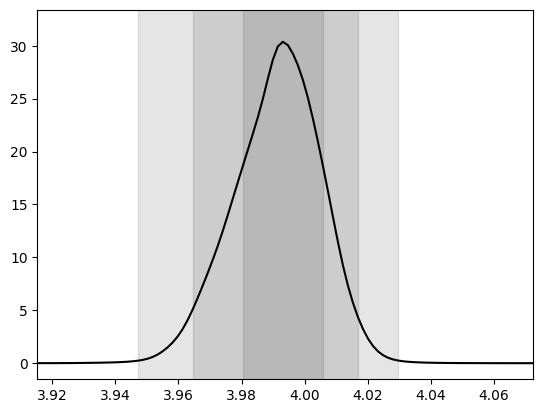

100%|█████████████████████████████████████| 3000/3000 [00:02<00:00, 1275.26it/s]
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name  | Type                   | Params
-------------------------------------------------
0 | cnn3  | Sequential             | 0     
1 | mlp3  | Sequential             | 0     
2 | lre3  | LogRatioEstimator_1dim | 135 K 
3 | norm3 | LazyBatchNorm2d        | 0     
-------------------------------------------------
135 K     Trainable params
0         Non-trainable params
135 K     Total params
0.540     Total estimated model params size (MB)


Epoch 0:  88%|█████████▋ | 38/43 [00:01<00:00, 30.38it/s, loss=-0.145, v_num=24]
Validation: 0it [00:00, ?it/s]
Epoch 0:  98%|██████████▋| 42/43 [00:01<00:00, 30.95it/s, loss=-0.145, v_num=24]
Epoch 0: 100%|█| 43/43 [00:01<00:00, 31.06it/s, loss=-0.145, v_num=24, val_loss=
                                                                                

Metric val_loss improved. New best score: 0.347


Epoch 1:  88%|▉| 38/43 [00:01<00:00, 28.61it/s, loss=-0.25, v_num=24, val_loss=0
Validation: 0it [00:00, ?it/s]
Validation DataLoader 0:   0%|                            | 0/5 [00:00<?, ?it/s]
Epoch 1:  91%|▉| 39/43 [00:01<00:00, 28.46it/s, loss=-0.25, v_num=24, val_loss=0
Epoch 1:  93%|▉| 40/43 [00:01<00:00, 28.74it/s, loss=-0.25, v_num=24, val_loss=0
Epoch 1:  95%|▉| 41/43 [00:01<00:00, 29.09it/s, loss=-0.25, v_num=24, val_loss=0
Epoch 1:  98%|▉| 42/43 [00:01<00:00, 29.49it/s, loss=-0.25, v_num=24, val_loss=0
Epoch 1: 100%|█| 43/43 [00:01<00:00, 29.71it/s, loss=-0.25, v_num=24, val_loss=0
Epoch 2:  88%|▉| 38/43 [00:01<00:00, 30.58it/s, loss=-0.373, v_num=24, val_loss=
Validation: 0it [00:00, ?it/s]
Validation DataLoader 0:   0%|                            | 0/5 [00:00<?, ?it/s]
Epoch 2:  91%|▉| 39/43 [00:01<00:00, 30.59it/s, loss=-0.373, v_num=24, val_loss=
Epoch 2:  93%|▉| 40/43 [00:01<00:00, 30.88it/s, loss=-0.373, v_num=24, val_loss=
Epoch 2:  95%|▉| 41/43 [00:01<00:00, 31.25it/s,

Metric val_loss improved by 0.031 >= min_delta = 0.0. New best score: 0.317


Epoch 10:  88%|▉| 38/43 [00:01<00:00, 27.63it/s, loss=-0.876, v_num=24, val_loss
Validation: 0it [00:00, ?it/s]
Validation DataLoader 0:   0%|                            | 0/5 [00:00<?, ?it/s]
Epoch 10:  91%|▉| 39/43 [00:01<00:00, 27.55it/s, loss=-0.876, v_num=24, val_loss
Epoch 10:  93%|▉| 40/43 [00:01<00:00, 27.88it/s, loss=-0.876, v_num=24, val_loss
Epoch 10:  95%|▉| 41/43 [00:01<00:00, 28.13it/s, loss=-0.876, v_num=24, val_loss
Epoch 10:  98%|▉| 42/43 [00:01<00:00, 28.43it/s, loss=-0.876, v_num=24, val_loss
Epoch 10: 100%|█| 43/43 [00:01<00:00, 28.64it/s, loss=-0.876, v_num=24, val_loss
                                                                                

Metric val_loss improved by 0.151 >= min_delta = 0.0. New best score: 0.166


Epoch 11:  88%|▉| 38/43 [00:01<00:00, 27.94it/s, loss=-0.879, v_num=24, val_loss
Validation: 0it [00:00, ?it/s]
Validation DataLoader 0:   0%|                            | 0/5 [00:00<?, ?it/s]
Epoch 11:  91%|▉| 39/43 [00:01<00:00, 28.04it/s, loss=-0.879, v_num=24, val_loss
Epoch 11:  93%|▉| 40/43 [00:01<00:00, 28.34it/s, loss=-0.879, v_num=24, val_loss
Epoch 11:  95%|▉| 41/43 [00:01<00:00, 28.72it/s, loss=-0.879, v_num=24, val_loss
Epoch 11:  98%|▉| 42/43 [00:01<00:00, 29.14it/s, loss=-0.879, v_num=24, val_loss
Epoch 11: 100%|█| 43/43 [00:01<00:00, 29.49it/s, loss=-0.879, v_num=24, val_loss
                                                                                

Metric val_loss improved by 0.055 >= min_delta = 0.0. New best score: 0.111


Epoch 12:  88%|▉| 38/43 [00:01<00:00, 31.60it/s, loss=-0.887, v_num=24, val_loss
Validation: 0it [00:00, ?it/s]
Validation DataLoader 0:   0%|                            | 0/5 [00:00<?, ?it/s]
Epoch 12:  91%|▉| 39/43 [00:01<00:00, 31.63it/s, loss=-0.887, v_num=24, val_loss
Epoch 12:  93%|▉| 40/43 [00:01<00:00, 31.93it/s, loss=-0.887, v_num=24, val_loss
Epoch 12:  95%|▉| 41/43 [00:01<00:00, 32.30it/s, loss=-0.887, v_num=24, val_loss
Epoch 12:  98%|▉| 42/43 [00:01<00:00, 32.60it/s, loss=-0.887, v_num=24, val_loss
Epoch 12: 100%|█| 43/43 [00:01<00:00, 32.75it/s, loss=-0.887, v_num=24, val_loss
                                                                                

Metric val_loss improved by 0.043 >= min_delta = 0.0. New best score: 0.068


Epoch 13:  88%|▉| 38/43 [00:01<00:00, 25.67it/s, loss=-0.895, v_num=24, val_loss
Validation: 0it [00:00, ?it/s]
Validation DataLoader 0:   0%|                            | 0/5 [00:00<?, ?it/s]
Epoch 13:  91%|▉| 39/43 [00:01<00:00, 25.82it/s, loss=-0.895, v_num=24, val_loss
Epoch 13:  93%|▉| 40/43 [00:01<00:00, 26.14it/s, loss=-0.895, v_num=24, val_loss
Epoch 13:  95%|▉| 41/43 [00:01<00:00, 26.43it/s, loss=-0.895, v_num=24, val_loss
Epoch 13:  98%|▉| 42/43 [00:01<00:00, 26.78it/s, loss=-0.895, v_num=24, val_loss
Epoch 13: 100%|█| 43/43 [00:01<00:00, 27.01it/s, loss=-0.895, v_num=24, val_loss
                                                                                

Metric val_loss improved by 0.008 >= min_delta = 0.0. New best score: 0.059


Epoch 14:  88%|▉| 38/43 [00:01<00:00, 28.98it/s, loss=-0.905, v_num=24, val_loss
Validation: 0it [00:00, ?it/s]
Validation DataLoader 0:   0%|                            | 0/5 [00:00<?, ?it/s]
Epoch 14:  91%|▉| 39/43 [00:01<00:00, 28.86it/s, loss=-0.905, v_num=24, val_loss
Epoch 14:  93%|▉| 40/43 [00:01<00:00, 29.15it/s, loss=-0.905, v_num=24, val_loss
Epoch 14:  95%|▉| 41/43 [00:01<00:00, 29.50it/s, loss=-0.905, v_num=24, val_loss
Epoch 14:  98%|▉| 42/43 [00:01<00:00, 29.79it/s, loss=-0.905, v_num=24, val_loss
Epoch 14: 100%|█| 43/43 [00:01<00:00, 30.02it/s, loss=-0.905, v_num=24, val_loss
                                                                                

Metric val_loss improved by 0.006 >= min_delta = 0.0. New best score: 0.053


Epoch 15:  88%|▉| 38/43 [00:01<00:00, 28.72it/s, loss=-0.909, v_num=24, val_loss
Validation: 0it [00:00, ?it/s]
Validation DataLoader 0:   0%|                            | 0/5 [00:00<?, ?it/s]
Epoch 15:  91%|▉| 39/43 [00:01<00:00, 28.59it/s, loss=-0.909, v_num=24, val_loss
Epoch 15:  93%|▉| 40/43 [00:01<00:00, 28.91it/s, loss=-0.909, v_num=24, val_loss
Epoch 15:  95%|▉| 41/43 [00:01<00:00, 29.26it/s, loss=-0.909, v_num=24, val_loss
Epoch 15:  98%|▉| 42/43 [00:01<00:00, 29.52it/s, loss=-0.909, v_num=24, val_loss
Epoch 15: 100%|█| 43/43 [00:01<00:00, 29.66it/s, loss=-0.909, v_num=24, val_loss
                                                                                

Metric val_loss improved by 0.010 >= min_delta = 0.0. New best score: 0.043


Epoch 16:  88%|▉| 38/43 [00:01<00:00, 26.28it/s, loss=-0.916, v_num=24, val_loss
Validation: 0it [00:00, ?it/s]
Validation DataLoader 0:   0%|                            | 0/5 [00:00<?, ?it/s]
Epoch 16:  91%|▉| 39/43 [00:01<00:00, 26.50it/s, loss=-0.916, v_num=24, val_loss
Epoch 16:  93%|▉| 40/43 [00:01<00:00, 26.92it/s, loss=-0.916, v_num=24, val_loss
Epoch 16:  95%|▉| 41/43 [00:01<00:00, 27.32it/s, loss=-0.916, v_num=24, val_loss
Epoch 16:  98%|▉| 42/43 [00:01<00:00, 27.75it/s, loss=-0.916, v_num=24, val_loss
Epoch 16: 100%|█| 43/43 [00:01<00:00, 28.11it/s, loss=-0.916, v_num=24, val_loss
Epoch 17:  88%|▉| 38/43 [00:01<00:00, 24.65it/s, loss=-0.913, v_num=24, val_loss
Validation: 0it [00:00, ?it/s]
Validation DataLoader 0:   0%|                            | 0/5 [00:00<?, ?it/s]
Epoch 17:  91%|▉| 39/43 [00:01<00:00, 24.74it/s, loss=-0.913, v_num=24, val_loss
Epoch 17:  93%|▉| 40/43 [00:01<00:00, 25.03it/s, loss=-0.913, v_num=24, val_loss
Epoch 17:  95%|▉| 41/43 [00:01<00:00, 25.37it/s

Monitored metric val_loss did not improve in the last 10 records. Best score: 0.043. Signaling Trainer to stop.


Epoch 25: 100%|█| 43/43 [00:01<00:00, 31.89it/s, loss=-0.943, v_num=24, val_loss


Restoring states from the checkpoint path at /home/cweniger/swyft/notebooks/dev/lightning_logs/version_24/checkpoints/rings_epoch=15_val_loss=0.04_train_loss=-1.02.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from checkpoint at /home/cweniger/swyft/notebooks/dev/lightning_logs/version_24/checkpoints/rings_epoch=15_val_loss=0.04_train_loss=-1.02.ckpt


Testing DataLoader 0: 100%|███████████████████████| 5/5 [00:00<00:00, 83.54it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           -0.1878877580165863
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


In [137]:
# Estimate theta from free x - round 1
while True:
    sim, samples = get_samples(n_sims = 3000, bounds = bounds_delta_x, bounds_theta = bounds_theta_x)
    trained_theta_x = train_theta_x(samples, max_epochs = 100)
    if trained_theta_x[2] > -0.2:
        print("Emotional damage")
        break
    results_theta_x, bounds_theta_x = infer_theta_x(sample0, sim, *trained_theta_x)

In [183]:
print("Bounds for theta", bounds_theta_x)

Bounds for theta tensor([[3.9999, 4.0001]])


### Round 2

100%|█████████████████████████████████████| 1000/1000 [00:00<00:00, 1317.57it/s]
/home/cweniger/.pyenv/versions/3.10.11/lib/python3.10/site-packages/torch/nn/modules/lazy.py:178: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '
/home/cweniger/.pyenv/versions/3.10.11/lib/python3.10/site-packages/lightning_fabric/plugins/environments/slurm.py:166: PossibleUserWarning: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python3.10 /home/cweniger/.pyenv/versions/3.10.11/lib/pytho ...
  rank_zero_warn(
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/home/cweniger/.pyenv/versions/3.10.11/lib/python3.10/site-packages

Sanity Checking DataLoader 0:   0%|                       | 0/2 [00:00<?, ?it/s]

/home/cweniger/.pyenv/versions/3.10.11/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:224: PossibleUserWarning: The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 20 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


/home/cweniger/.pyenv/versions/3.10.11/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:224: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 20 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(
/home/cweniger/.pyenv/versions/3.10.11/lib/python3.10/site-packages/pytorch_lightning/trainer/trainer.py:1600: PossibleUserWarning: The number of training batches (13) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.
  rank_zero_warn(


Epoch 0:  87%|██████▉ | 13/15 [00:00<00:00, 13.81it/s, loss=-4.32e+03, v_num=68]
Validation: 0it [00:00, ?it/s]
Epoch 0:  93%|███████▍| 14/15 [00:01<00:00, 13.93it/s, loss=-4.32e+03, v_num=68]
Epoch 0: 100%|█| 15/15 [00:01<00:00, 14.48it/s, loss=-4.32e+03, v_num=68, val_lo
                                                                                

Metric val_loss improved. New best score: -4716.508


Epoch 1:  87%|▊| 13/15 [00:00<00:00, 17.93it/s, loss=-5.14e+03, v_num=68, val_lo
Validation: 0it [00:00, ?it/s]
Validation DataLoader 0:   0%|                            | 0/2 [00:00<?, ?it/s]
Epoch 1:  93%|▉| 14/15 [00:00<00:00, 18.06it/s, loss=-5.14e+03, v_num=68, val_lo
Epoch 1: 100%|█| 15/15 [00:00<00:00, 18.35it/s, loss=-5.14e+03, v_num=68, val_lo
                                                                                

Metric val_loss improved by 479.461 >= min_delta = 0.0. New best score: -5195.969


Epoch 2:  87%|▊| 13/15 [00:00<00:00, 18.90it/s, loss=-5.51e+03, v_num=68, val_lo
Validation: 0it [00:00, ?it/s]
Validation DataLoader 0:   0%|                            | 0/2 [00:00<?, ?it/s]
Epoch 2:  93%|▉| 14/15 [00:00<00:00, 19.08it/s, loss=-5.51e+03, v_num=68, val_lo
Epoch 2: 100%|█| 15/15 [00:00<00:00, 19.73it/s, loss=-5.51e+03, v_num=68, val_lo
                                                                                

Metric val_loss improved by 280.293 >= min_delta = 0.0. New best score: -5476.262


Epoch 3:  87%|▊| 13/15 [00:00<00:00, 17.17it/s, loss=-5.78e+03, v_num=68, val_lo
Validation: 0it [00:00, ?it/s]
Validation DataLoader 0:   0%|                            | 0/2 [00:00<?, ?it/s]
Epoch 3:  93%|▉| 14/15 [00:00<00:00, 17.22it/s, loss=-5.78e+03, v_num=68, val_lo
Epoch 3: 100%|█| 15/15 [00:00<00:00, 17.51it/s, loss=-5.78e+03, v_num=68, val_lo
                                                                                

Metric val_loss improved by 223.272 >= min_delta = 0.0. New best score: -5699.534


Epoch 4:  87%|▊| 13/15 [00:00<00:00, 16.14it/s, loss=-6e+03, v_num=68, val_loss=
Validation: 0it [00:00, ?it/s]
Validation DataLoader 0:   0%|                            | 0/2 [00:00<?, ?it/s]
Epoch 4:  93%|▉| 14/15 [00:00<00:00, 16.21it/s, loss=-6e+03, v_num=68, val_loss=
Epoch 4: 100%|█| 15/15 [00:00<00:00, 16.81it/s, loss=-6e+03, v_num=68, val_loss=
                                                                                

Metric val_loss improved by 229.606 >= min_delta = 0.0. New best score: -5929.140


Epoch 5:  87%|▊| 13/15 [00:00<00:00, 17.58it/s, loss=-6.2e+03, v_num=68, val_los
Validation: 0it [00:00, ?it/s]
Validation DataLoader 0:   0%|                            | 0/2 [00:00<?, ?it/s]
Epoch 5:  93%|▉| 14/15 [00:00<00:00, 17.76it/s, loss=-6.2e+03, v_num=68, val_los
Epoch 5: 100%|█| 15/15 [00:00<00:00, 18.42it/s, loss=-6.2e+03, v_num=68, val_los
                                                                                

Metric val_loss improved by 205.698 >= min_delta = 0.0. New best score: -6134.838


Epoch 6:  87%|▊| 13/15 [00:00<00:00, 19.46it/s, loss=-6.38e+03, v_num=68, val_lo
Validation: 0it [00:00, ?it/s]
Validation DataLoader 0:   0%|                            | 0/2 [00:00<?, ?it/s]
Epoch 6:  93%|▉| 14/15 [00:00<00:00, 19.38it/s, loss=-6.38e+03, v_num=68, val_lo
Epoch 6: 100%|█| 15/15 [00:00<00:00, 19.83it/s, loss=-6.38e+03, v_num=68, val_lo
                                                                                

Metric val_loss improved by 185.924 >= min_delta = 0.0. New best score: -6320.762


Epoch 7:  87%|▊| 13/15 [00:00<00:00, 18.65it/s, loss=-6.54e+03, v_num=68, val_lo
Validation: 0it [00:00, ?it/s]
Validation DataLoader 0:   0%|                            | 0/2 [00:00<?, ?it/s]
Epoch 7:  93%|▉| 14/15 [00:00<00:00, 18.20it/s, loss=-6.54e+03, v_num=68, val_lo
Epoch 7: 100%|█| 15/15 [00:00<00:00, 18.29it/s, loss=-6.54e+03, v_num=68, val_lo
                                                                                

Metric val_loss improved by 160.373 >= min_delta = 0.0. New best score: -6481.134


Epoch 8:  87%|▊| 13/15 [00:00<00:00, 18.41it/s, loss=-6.68e+03, v_num=68, val_lo
Validation: 0it [00:00, ?it/s]
Validation DataLoader 0:   0%|                            | 0/2 [00:00<?, ?it/s]
Epoch 8:  93%|▉| 14/15 [00:00<00:00, 18.36it/s, loss=-6.68e+03, v_num=68, val_lo
Epoch 8: 100%|█| 15/15 [00:00<00:00, 18.42it/s, loss=-6.68e+03, v_num=68, val_lo
                                                                                

Metric val_loss improved by 142.064 >= min_delta = 0.0. New best score: -6623.198


Epoch 9:  87%|▊| 13/15 [00:00<00:00, 19.09it/s, loss=-6.8e+03, v_num=68, val_los
Validation: 0it [00:00, ?it/s]
Validation DataLoader 0:   0%|                            | 0/2 [00:00<?, ?it/s]
Epoch 9:  93%|▉| 14/15 [00:00<00:00, 19.25it/s, loss=-6.8e+03, v_num=68, val_los
Epoch 9: 100%|█| 15/15 [00:00<00:00, 19.37it/s, loss=-6.8e+03, v_num=68, val_los
                                                                                

Metric val_loss improved by 118.905 >= min_delta = 0.0. New best score: -6742.103


Epoch 10:  87%|▊| 13/15 [00:00<00:00, 16.11it/s, loss=-6.9e+03, v_num=68, val_lo
Validation: 0it [00:00, ?it/s]
Validation DataLoader 0:   0%|                            | 0/2 [00:00<?, ?it/s]
Epoch 10:  93%|▉| 14/15 [00:00<00:00, 16.32it/s, loss=-6.9e+03, v_num=68, val_lo
Epoch 10: 100%|█| 15/15 [00:00<00:00, 16.88it/s, loss=-6.9e+03, v_num=68, val_lo
                                                                                

Metric val_loss improved by 104.528 >= min_delta = 0.0. New best score: -6846.632


Epoch 11:  87%|▊| 13/15 [00:00<00:00, 17.20it/s, loss=-6.99e+03, v_num=68, val_l
Validation: 0it [00:00, ?it/s]
Validation DataLoader 0:   0%|                            | 0/2 [00:00<?, ?it/s]
Epoch 11:  93%|▉| 14/15 [00:00<00:00, 17.55it/s, loss=-6.99e+03, v_num=68, val_l
Epoch 11: 100%|█| 15/15 [00:00<00:00, 18.18it/s, loss=-6.99e+03, v_num=68, val_l
                                                                                

Metric val_loss improved by 78.291 >= min_delta = 0.0. New best score: -6924.922


Epoch 12:  87%|▊| 13/15 [00:00<00:00, 16.27it/s, loss=-7.06e+03, v_num=68, val_l
Validation: 0it [00:00, ?it/s]
Validation DataLoader 0:   0%|                            | 0/2 [00:00<?, ?it/s]
Epoch 12:  93%|▉| 14/15 [00:00<00:00, 16.19it/s, loss=-7.06e+03, v_num=68, val_l
Epoch 12: 100%|█| 15/15 [00:00<00:00, 16.45it/s, loss=-7.06e+03, v_num=68, val_l
                                                                                

Metric val_loss improved by 67.085 >= min_delta = 0.0. New best score: -6992.007


Epoch 13:  87%|▊| 13/15 [00:00<00:00, 16.73it/s, loss=-7.1e+03, v_num=68, val_lo
Validation: 0it [00:00, ?it/s]
Validation DataLoader 0:   0%|                            | 0/2 [00:00<?, ?it/s]
Epoch 13:  93%|▉| 14/15 [00:00<00:00, 16.70it/s, loss=-7.1e+03, v_num=68, val_lo
Epoch 13: 100%|█| 15/15 [00:00<00:00, 16.99it/s, loss=-7.1e+03, v_num=68, val_lo
                                                                                

Metric val_loss improved by 41.149 >= min_delta = 0.0. New best score: -7033.156


Epoch 14:  87%|▊| 13/15 [00:00<00:00, 15.94it/s, loss=-7.14e+03, v_num=68, val_l
Validation: 0it [00:00, ?it/s]
Validation DataLoader 0:   0%|                            | 0/2 [00:00<?, ?it/s]
Epoch 14:  93%|▉| 14/15 [00:00<00:00, 16.07it/s, loss=-7.14e+03, v_num=68, val_l
Epoch 14: 100%|█| 15/15 [00:00<00:00, 16.68it/s, loss=-7.14e+03, v_num=68, val_l
                                                                                

Metric val_loss improved by 22.663 >= min_delta = 0.0. New best score: -7055.819


Epoch 15:  87%|▊| 13/15 [00:00<00:00, 18.67it/s, loss=-7.16e+03, v_num=68, val_l
Validation: 0it [00:00, ?it/s]
Validation DataLoader 0:   0%|                            | 0/2 [00:00<?, ?it/s]
Epoch 15:  93%|▉| 14/15 [00:00<00:00, 18.94it/s, loss=-7.16e+03, v_num=68, val_l
Epoch 15: 100%|█| 15/15 [00:00<00:00, 19.26it/s, loss=-7.16e+03, v_num=68, val_l
                                                                                

Metric val_loss improved by 69.522 >= min_delta = 0.0. New best score: -7125.341


Epoch 16:  87%|▊| 13/15 [00:00<00:00, 17.87it/s, loss=-7.18e+03, v_num=68, val_l
Validation: 0it [00:00, ?it/s]
Validation DataLoader 0:   0%|                            | 0/2 [00:00<?, ?it/s]
Epoch 16:  93%|▉| 14/15 [00:00<00:00, 17.82it/s, loss=-7.18e+03, v_num=68, val_l
Epoch 16: 100%|█| 15/15 [00:00<00:00, 18.12it/s, loss=-7.18e+03, v_num=68, val_l
                                                                                

Metric val_loss improved by 20.543 >= min_delta = 0.0. New best score: -7145.884


Epoch 17:  87%|▊| 13/15 [00:00<00:00, 15.20it/s, loss=-7.19e+03, v_num=68, val_l
Validation: 0it [00:00, ?it/s]
Validation DataLoader 0:   0%|                            | 0/2 [00:00<?, ?it/s]
Epoch 17:  93%|▉| 14/15 [00:00<00:00, 15.22it/s, loss=-7.19e+03, v_num=68, val_l
Epoch 17: 100%|█| 15/15 [00:00<00:00, 15.56it/s, loss=-7.19e+03, v_num=68, val_l
                                                                                

Metric val_loss improved by 15.718 >= min_delta = 0.0. New best score: -7161.602


Epoch 18:  87%|▊| 13/15 [00:00<00:00, 15.42it/s, loss=-7.19e+03, v_num=68, val_l
Validation: 0it [00:00, ?it/s]
Validation DataLoader 0:   0%|                            | 0/2 [00:00<?, ?it/s]
Epoch 18:  93%|▉| 14/15 [00:00<00:00, 15.52it/s, loss=-7.19e+03, v_num=68, val_l
Epoch 18: 100%|█| 15/15 [00:00<00:00, 16.07it/s, loss=-7.19e+03, v_num=68, val_l
                                                                                

Metric val_loss improved by 37.614 >= min_delta = 0.0. New best score: -7199.215


Epoch 19:  87%|▊| 13/15 [00:00<00:00, 14.87it/s, loss=-7.2e+03, v_num=68, val_lo
Validation: 0it [00:00, ?it/s]
Validation DataLoader 0:   0%|                            | 0/2 [00:00<?, ?it/s]
Epoch 19:  93%|▉| 14/15 [00:00<00:00, 15.19it/s, loss=-7.2e+03, v_num=68, val_lo
Epoch 19: 100%|█| 15/15 [00:00<00:00, 15.79it/s, loss=-7.2e+03, v_num=68, val_lo
Epoch 20:  87%|▊| 13/15 [00:00<00:00, 19.83it/s, loss=-7.21e+03, v_num=68, val_l
Validation: 0it [00:00, ?it/s]
Validation DataLoader 0:   0%|                            | 0/2 [00:00<?, ?it/s]
Epoch 20:  93%|▉| 14/15 [00:00<00:00, 20.38it/s, loss=-7.21e+03, v_num=68, val_l
Epoch 20: 100%|█| 15/15 [00:00<00:00, 21.19it/s, loss=-7.21e+03, v_num=68, val_l
                                                                                

Metric val_loss improved by 25.203 >= min_delta = 0.0. New best score: -7224.418


Epoch 21:  87%|▊| 13/15 [00:00<00:00, 17.14it/s, loss=-7.23e+03, v_num=68, val_l
Validation: 0it [00:00, ?it/s]
Validation DataLoader 0:   0%|                            | 0/2 [00:00<?, ?it/s]
Epoch 21:  93%|▉| 14/15 [00:00<00:00, 17.19it/s, loss=-7.23e+03, v_num=68, val_l
Epoch 21: 100%|█| 15/15 [00:00<00:00, 17.46it/s, loss=-7.23e+03, v_num=68, val_l
                                                                                

Metric val_loss improved by 40.668 >= min_delta = 0.0. New best score: -7265.086


Epoch 22:  87%|▊| 13/15 [00:00<00:00, 16.23it/s, loss=-7.27e+03, v_num=68, val_l
Validation: 0it [00:00, ?it/s]
Validation DataLoader 0:   0%|                            | 0/2 [00:00<?, ?it/s]
Epoch 22:  93%|▉| 14/15 [00:00<00:00, 16.06it/s, loss=-7.27e+03, v_num=68, val_l
Epoch 22: 100%|█| 15/15 [00:00<00:00, 16.36it/s, loss=-7.27e+03, v_num=68, val_l
Epoch 23:  87%|▊| 13/15 [00:00<00:00, 16.89it/s, loss=-7.29e+03, v_num=68, val_l
Validation: 0it [00:00, ?it/s]
Validation DataLoader 0:   0%|                            | 0/2 [00:00<?, ?it/s]
Epoch 23:  93%|▉| 14/15 [00:00<00:00, 16.72it/s, loss=-7.29e+03, v_num=68, val_l
Epoch 23: 100%|█| 15/15 [00:00<00:00, 17.15it/s, loss=-7.29e+03, v_num=68, val_l
Epoch 24:  87%|▊| 13/15 [00:00<00:00, 18.16it/s, loss=-7.3e+03, v_num=68, val_lo
Validation: 0it [00:00, ?it/s]
Validation DataLoader 0:   0%|                            | 0/2 [00:00<?, ?it/s]
Epoch 24:  93%|▉| 14/15 [00:00<00:00, 18.00it/s, loss=-7.3e+03, v_num=68, val_lo
Epoch 24: 100%|█

Metric val_loss improved by 37.434 >= min_delta = 0.0. New best score: -7302.520


Epoch 27:  87%|▊| 13/15 [00:00<00:00, 18.71it/s, loss=-7.38e+03, v_num=68, val_l
Validation: 0it [00:00, ?it/s]
Validation DataLoader 0:   0%|                            | 0/2 [00:00<?, ?it/s]
Epoch 27:  93%|▉| 14/15 [00:00<00:00, 18.91it/s, loss=-7.38e+03, v_num=68, val_l
Epoch 27: 100%|█| 15/15 [00:00<00:00, 19.07it/s, loss=-7.38e+03, v_num=68, val_l
                                                                                

Metric val_loss improved by 4.049 >= min_delta = 0.0. New best score: -7306.569


Epoch 28:  87%|▊| 13/15 [00:00<00:00, 16.29it/s, loss=-7.39e+03, v_num=68, val_l
Validation: 0it [00:00, ?it/s]
Validation DataLoader 0:   0%|                            | 0/2 [00:00<?, ?it/s]
Epoch 28:  93%|▉| 14/15 [00:00<00:00, 16.29it/s, loss=-7.39e+03, v_num=68, val_l
Epoch 28: 100%|█| 15/15 [00:00<00:00, 16.43it/s, loss=-7.39e+03, v_num=68, val_l
                                                                                

Metric val_loss improved by 7.718 >= min_delta = 0.0. New best score: -7314.287


Epoch 29:  87%|▊| 13/15 [00:00<00:00, 15.47it/s, loss=-7.4e+03, v_num=68, val_lo
Validation: 0it [00:00, ?it/s]
Validation DataLoader 0:   0%|                            | 0/2 [00:00<?, ?it/s]
Epoch 29:  93%|▉| 14/15 [00:00<00:00, 15.74it/s, loss=-7.4e+03, v_num=68, val_lo
Epoch 29: 100%|█| 15/15 [00:00<00:00, 16.10it/s, loss=-7.4e+03, v_num=68, val_lo
                                                                                

Metric val_loss improved by 0.526 >= min_delta = 0.0. New best score: -7314.813


Epoch 30:  87%|▊| 13/15 [00:00<00:00, 17.41it/s, loss=-7.4e+03, v_num=68, val_lo
Validation: 0it [00:00, ?it/s]
Validation DataLoader 0:   0%|                            | 0/2 [00:00<?, ?it/s]
Epoch 30:  93%|▉| 14/15 [00:00<00:00, 17.64it/s, loss=-7.4e+03, v_num=68, val_lo
Epoch 30: 100%|█| 15/15 [00:00<00:00, 18.00it/s, loss=-7.4e+03, v_num=68, val_lo
                                                                                

Metric val_loss improved by 1.682 >= min_delta = 0.0. New best score: -7316.494


Epoch 31:  87%|▊| 13/15 [00:00<00:00, 17.55it/s, loss=-7.41e+03, v_num=68, val_l
Validation: 0it [00:00, ?it/s]
Validation DataLoader 0:   0%|                            | 0/2 [00:00<?, ?it/s]
Epoch 31:  93%|▉| 14/15 [00:00<00:00, 17.44it/s, loss=-7.41e+03, v_num=68, val_l
Epoch 31: 100%|█| 15/15 [00:00<00:00, 17.70it/s, loss=-7.41e+03, v_num=68, val_l
Epoch 32:  87%|▊| 13/15 [00:00<00:00, 17.63it/s, loss=-7.41e+03, v_num=68, val_l
Validation: 0it [00:00, ?it/s]
Validation DataLoader 0:   0%|                            | 0/2 [00:00<?, ?it/s]
Epoch 32:  93%|▉| 14/15 [00:00<00:00, 17.60it/s, loss=-7.41e+03, v_num=68, val_l
Epoch 32: 100%|█| 15/15 [00:00<00:00, 18.24it/s, loss=-7.41e+03, v_num=68, val_l
Epoch 33:  87%|▊| 13/15 [00:00<00:00, 18.09it/s, loss=-7.42e+03, v_num=68, val_l
Validation: 0it [00:00, ?it/s]
Validation DataLoader 0:   0%|                            | 0/2 [00:00<?, ?it/s]
Epoch 33:  93%|▉| 14/15 [00:00<00:00, 18.23it/s, loss=-7.42e+03, v_num=68, val_l
Epoch 33: 100%|█

Monitored metric val_loss did not improve in the last 10 records. Best score: -7316.494. Signaling Trainer to stop.


Epoch 40: 100%|█| 15/15 [00:00<00:00, 19.93it/s, loss=-7.44e+03, v_num=68, val_l


Restoring states from the checkpoint path at /home/cweniger/swyft/notebooks/dev/lightning_logs/version_68/checkpoints/rongs_epoch=30_val_loss=-7316.49_train_loss=-7507.69.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from checkpoint at /home/cweniger/swyft/notebooks/dev/lightning_logs/version_68/checkpoints/rongs_epoch=30_val_loss=-7316.49_train_loss=-7507.69.ckpt
/home/cweniger/.pyenv/versions/3.10.11/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:224: PossibleUserWarning: The dataloader, test_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 20 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Testing DataLoader 0: 100%|███████████████████████| 2/2 [00:00<00:00, 32.61it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           -7531.479433031232
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


100%|███████████████████████████████████████| 1000/1000 [02:04<00:00,  8.04it/s]


0.029589355 6.047198 -12.800168771614668 9.19880416030522


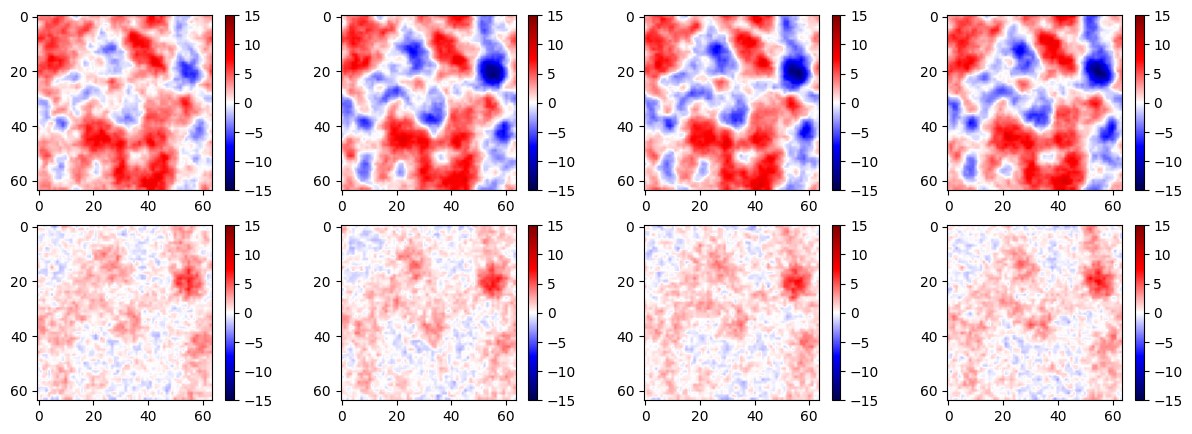

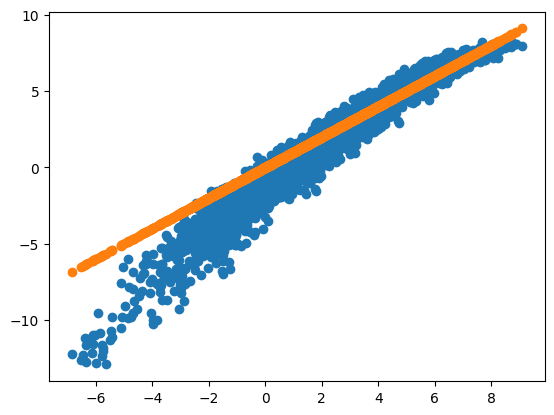

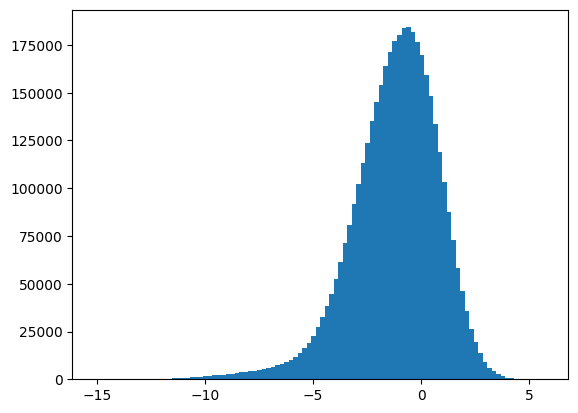

Residual percentiles: [-5.86580306 -3.06262058 -1.03171472  0.67887097  2.10807951]


100%|███████████████████████████████████████| 100/100 [00:00<00:00, 1453.14it/s]


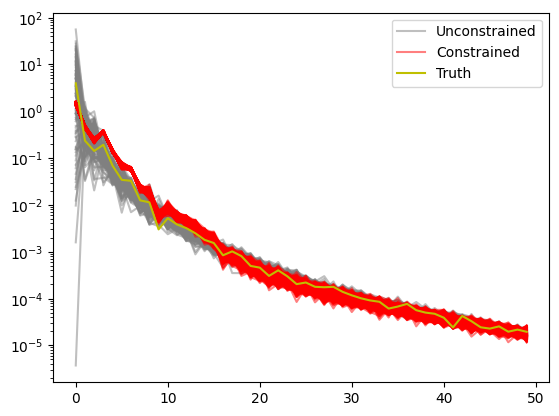

In [12]:
# Estimate delta from free x - round 4
sim, samples = get_samples(n_sims = 1000, bounds = bounds_delta_x, bounds_theta = bounds_theta_x)
trained_delta_x = train_delta_x(samples, max_epochs = 100)
bounds_delta_x = infer_delta_x(sample0, sim, *trained_delta_x, n_draws = 1000, gamma = 0.1)

100%|█████████████████████████████████████| 1000/1000 [00:00<00:00, 1723.06it/s]
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name  | Type                                                     | Params
-----------------------------------------------------------------------------------
0 | lre   | LogRatioEstimator_Gaussian_Autoregressive_X_module_based | 0     
1 | unet  | UNet                                                     | 1.9 M 
2 | norm1 | LazyBatchNorm2d                                          | 0     
-----------------------------------------------------------------------------------
1.9 M     Trainable params
0         Non-trainable params
1.9 M     Total params
7.769     Total estimated model params size (MB)


Epoch 0:  87%|███████▊ | 13/15 [00:00<00:00, 18.06it/s, loss=1.82e+03, v_num=69]
Validation: 0it [00:00, ?it/s]
Epoch 0:  93%|████████▍| 14/15 [00:00<00:00, 18.00it/s, loss=1.82e+03, v_num=69]
Epoch 0: 100%|█| 15/15 [00:00<00:00, 18.18it/s, loss=1.82e+03, v_num=69, val_los
                                                                                

Metric val_loss improved. New best score: -2734.683


Epoch 1:  87%|▊| 13/15 [00:00<00:00, 17.30it/s, loss=-2.54e+03, v_num=69, val_lo
Validation: 0it [00:00, ?it/s]
Validation DataLoader 0:   0%|                            | 0/2 [00:00<?, ?it/s]
Epoch 1:  93%|▉| 14/15 [00:00<00:00, 17.46it/s, loss=-2.54e+03, v_num=69, val_lo
Epoch 1: 100%|█| 15/15 [00:00<00:00, 17.71it/s, loss=-2.54e+03, v_num=69, val_lo
                                                                                

Metric val_loss improved by 104.109 >= min_delta = 0.0. New best score: -2838.792


Epoch 2:  87%|▊| 13/15 [00:00<00:00, 17.12it/s, loss=-2.92e+03, v_num=69, val_lo
Validation: 0it [00:00, ?it/s]
Validation DataLoader 0:   0%|                            | 0/2 [00:00<?, ?it/s]
Epoch 2:  93%|▉| 14/15 [00:00<00:00, 17.04it/s, loss=-2.92e+03, v_num=69, val_lo
Epoch 2: 100%|█| 15/15 [00:00<00:00, 17.51it/s, loss=-2.92e+03, v_num=69, val_lo
                                                                                

Metric val_loss improved by 151.827 >= min_delta = 0.0. New best score: -2990.618


Epoch 3:  87%|▊| 13/15 [00:00<00:00, 19.46it/s, loss=-3e+03, v_num=69, val_loss=
Validation: 0it [00:00, ?it/s]
Validation DataLoader 0:   0%|                            | 0/2 [00:00<?, ?it/s]
Epoch 3:  93%|▉| 14/15 [00:00<00:00, 19.46it/s, loss=-3e+03, v_num=69, val_loss=
Epoch 3: 100%|█| 15/15 [00:00<00:00, 20.06it/s, loss=-3e+03, v_num=69, val_loss=
                                                                                

Metric val_loss improved by 44.744 >= min_delta = 0.0. New best score: -3035.362


Epoch 4:  87%|▊| 13/15 [00:00<00:00, 19.08it/s, loss=-3.04e+03, v_num=69, val_lo
Validation: 0it [00:00, ?it/s]
Validation DataLoader 0:   0%|                            | 0/2 [00:00<?, ?it/s]
Epoch 4:  93%|▉| 14/15 [00:00<00:00, 19.05it/s, loss=-3.04e+03, v_num=69, val_lo
Epoch 4: 100%|█| 15/15 [00:00<00:00, 19.72it/s, loss=-3.04e+03, v_num=69, val_lo
                                                                                

Metric val_loss improved by 25.247 >= min_delta = 0.0. New best score: -3060.609


Epoch 5:  87%|▊| 13/15 [00:00<00:00, 18.76it/s, loss=-3.07e+03, v_num=69, val_lo
Validation: 0it [00:00, ?it/s]
Validation DataLoader 0:   0%|                            | 0/2 [00:00<?, ?it/s]
Epoch 5:  93%|▉| 14/15 [00:00<00:00, 18.86it/s, loss=-3.07e+03, v_num=69, val_lo
Epoch 5: 100%|█| 15/15 [00:00<00:00, 19.53it/s, loss=-3.07e+03, v_num=69, val_lo
                                                                                

Metric val_loss improved by 22.049 >= min_delta = 0.0. New best score: -3082.658


Epoch 6:  87%|▊| 13/15 [00:00<00:00, 16.25it/s, loss=-3.1e+03, v_num=69, val_los
Validation: 0it [00:00, ?it/s]
Validation DataLoader 0:   0%|                            | 0/2 [00:00<?, ?it/s]
Epoch 6:  93%|▉| 14/15 [00:00<00:00, 16.10it/s, loss=-3.1e+03, v_num=69, val_los
Epoch 6: 100%|█| 15/15 [00:00<00:00, 16.60it/s, loss=-3.1e+03, v_num=69, val_los
                                                                                

Metric val_loss improved by 22.070 >= min_delta = 0.0. New best score: -3104.728


Epoch 7:  87%|▊| 13/15 [00:00<00:00, 15.78it/s, loss=-3.12e+03, v_num=69, val_lo
Validation: 0it [00:00, ?it/s]
Validation DataLoader 0:   0%|                            | 0/2 [00:00<?, ?it/s]
Epoch 7:  93%|▉| 14/15 [00:00<00:00, 16.11it/s, loss=-3.12e+03, v_num=69, val_lo
Epoch 7: 100%|█| 15/15 [00:00<00:00, 16.75it/s, loss=-3.12e+03, v_num=69, val_lo
                                                                                

Metric val_loss improved by 22.828 >= min_delta = 0.0. New best score: -3127.556


Epoch 8:  87%|▊| 13/15 [00:00<00:00, 18.15it/s, loss=-3.15e+03, v_num=69, val_lo
Validation: 0it [00:00, ?it/s]
Validation DataLoader 0:   0%|                            | 0/2 [00:00<?, ?it/s]
Epoch 8:  93%|▉| 14/15 [00:00<00:00, 18.17it/s, loss=-3.15e+03, v_num=69, val_lo
Epoch 8: 100%|█| 15/15 [00:00<00:00, 18.43it/s, loss=-3.15e+03, v_num=69, val_lo
                                                                                

Metric val_loss improved by 23.664 >= min_delta = 0.0. New best score: -3151.220


Epoch 9:  87%|▊| 13/15 [00:00<00:00, 17.52it/s, loss=-3.18e+03, v_num=69, val_lo
Validation: 0it [00:00, ?it/s]
Validation DataLoader 0:   0%|                            | 0/2 [00:00<?, ?it/s]
Epoch 9:  93%|▉| 14/15 [00:00<00:00, 17.65it/s, loss=-3.18e+03, v_num=69, val_lo
Epoch 9: 100%|█| 15/15 [00:00<00:00, 18.27it/s, loss=-3.18e+03, v_num=69, val_lo
                                                                                

Metric val_loss improved by 25.447 >= min_delta = 0.0. New best score: -3176.667


Epoch 10:  87%|▊| 13/15 [00:00<00:00, 17.26it/s, loss=-3.2e+03, v_num=69, val_lo
Validation: 0it [00:00, ?it/s]
Validation DataLoader 0:   0%|                            | 0/2 [00:00<?, ?it/s]
Epoch 10:  93%|▉| 14/15 [00:00<00:00, 17.40it/s, loss=-3.2e+03, v_num=69, val_lo
Epoch 10: 100%|█| 15/15 [00:00<00:00, 17.80it/s, loss=-3.2e+03, v_num=69, val_lo
                                                                                

Metric val_loss improved by 27.619 >= min_delta = 0.0. New best score: -3204.286


Epoch 11:  87%|▊| 13/15 [00:00<00:00, 16.40it/s, loss=-3.23e+03, v_num=69, val_l
Validation: 0it [00:00, ?it/s]
Validation DataLoader 0:   0%|                            | 0/2 [00:00<?, ?it/s]
Epoch 11:  93%|▉| 14/15 [00:00<00:00, 16.46it/s, loss=-3.23e+03, v_num=69, val_l
Epoch 11: 100%|█| 15/15 [00:00<00:00, 17.06it/s, loss=-3.23e+03, v_num=69, val_l
                                                                                

Metric val_loss improved by 27.412 >= min_delta = 0.0. New best score: -3231.698


Epoch 12:  87%|▊| 13/15 [00:00<00:00, 15.14it/s, loss=-3.26e+03, v_num=69, val_l
Validation: 0it [00:00, ?it/s]
Validation DataLoader 0:   0%|                            | 0/2 [00:00<?, ?it/s]
Epoch 12:  93%|▉| 14/15 [00:00<00:00, 15.31it/s, loss=-3.26e+03, v_num=69, val_l
Epoch 12: 100%|█| 15/15 [00:00<00:00, 15.61it/s, loss=-3.26e+03, v_num=69, val_l
                                                                                

Metric val_loss improved by 23.147 >= min_delta = 0.0. New best score: -3254.845


Epoch 13:  87%|▊| 13/15 [00:00<00:00, 18.52it/s, loss=-3.29e+03, v_num=69, val_l
Validation: 0it [00:00, ?it/s]
Validation DataLoader 0:   0%|                            | 0/2 [00:00<?, ?it/s]
Epoch 13:  93%|▉| 14/15 [00:00<00:00, 18.51it/s, loss=-3.29e+03, v_num=69, val_l
Epoch 13: 100%|█| 15/15 [00:00<00:00, 18.84it/s, loss=-3.29e+03, v_num=69, val_l
                                                                                

Metric val_loss improved by 18.066 >= min_delta = 0.0. New best score: -3272.911


Epoch 14:  87%|▊| 13/15 [00:00<00:00, 17.42it/s, loss=-3.31e+03, v_num=69, val_l
Validation: 0it [00:00, ?it/s]
Validation DataLoader 0:   0%|                            | 0/2 [00:00<?, ?it/s]
Epoch 14:  93%|▉| 14/15 [00:00<00:00, 17.35it/s, loss=-3.31e+03, v_num=69, val_l
Epoch 14: 100%|█| 15/15 [00:00<00:00, 17.77it/s, loss=-3.31e+03, v_num=69, val_l
                                                                                

Metric val_loss improved by 14.789 >= min_delta = 0.0. New best score: -3287.700


Epoch 15:  87%|▊| 13/15 [00:00<00:00, 19.02it/s, loss=-3.32e+03, v_num=69, val_l
Validation: 0it [00:00, ?it/s]
Validation DataLoader 0:   0%|                            | 0/2 [00:00<?, ?it/s]
Epoch 15:  93%|▉| 14/15 [00:00<00:00, 19.12it/s, loss=-3.32e+03, v_num=69, val_l
Epoch 15: 100%|█| 15/15 [00:00<00:00, 19.34it/s, loss=-3.32e+03, v_num=69, val_l
                                                                                

Metric val_loss improved by 12.377 >= min_delta = 0.0. New best score: -3300.077


Epoch 16:  87%|▊| 13/15 [00:00<00:00, 16.71it/s, loss=-3.34e+03, v_num=69, val_l
Validation: 0it [00:00, ?it/s]
Validation DataLoader 0:   0%|                            | 0/2 [00:00<?, ?it/s]
Epoch 16:  93%|▉| 14/15 [00:00<00:00, 16.62it/s, loss=-3.34e+03, v_num=69, val_l
Epoch 16: 100%|█| 15/15 [00:00<00:00, 16.77it/s, loss=-3.34e+03, v_num=69, val_l
                                                                                

Metric val_loss improved by 10.612 >= min_delta = 0.0. New best score: -3310.690


Epoch 17:  87%|▊| 13/15 [00:00<00:00, 17.81it/s, loss=-3.35e+03, v_num=69, val_l
Validation: 0it [00:00, ?it/s]
Validation DataLoader 0:   0%|                            | 0/2 [00:00<?, ?it/s]
Epoch 17:  93%|▉| 14/15 [00:00<00:00, 17.79it/s, loss=-3.35e+03, v_num=69, val_l
Epoch 17: 100%|█| 15/15 [00:00<00:00, 17.95it/s, loss=-3.35e+03, v_num=69, val_l
                                                                                

Metric val_loss improved by 9.333 >= min_delta = 0.0. New best score: -3320.023


Epoch 18:  87%|▊| 13/15 [00:00<00:00, 18.69it/s, loss=-3.36e+03, v_num=69, val_l
Validation: 0it [00:00, ?it/s]
Validation DataLoader 0:   0%|                            | 0/2 [00:00<?, ?it/s]
Epoch 18:  93%|▉| 14/15 [00:00<00:00, 18.79it/s, loss=-3.36e+03, v_num=69, val_l
Epoch 18: 100%|█| 15/15 [00:00<00:00, 19.38it/s, loss=-3.36e+03, v_num=69, val_l
                                                                                

Metric val_loss improved by 8.209 >= min_delta = 0.0. New best score: -3328.232


Epoch 19:  87%|▊| 13/15 [00:00<00:00, 17.17it/s, loss=-3.37e+03, v_num=69, val_l
Validation: 0it [00:00, ?it/s]
Validation DataLoader 0:   0%|                            | 0/2 [00:00<?, ?it/s]
Epoch 19:  93%|▉| 14/15 [00:00<00:00, 17.41it/s, loss=-3.37e+03, v_num=69, val_l
Epoch 19: 100%|█| 15/15 [00:00<00:00, 18.06it/s, loss=-3.37e+03, v_num=69, val_l
                                                                                

Metric val_loss improved by 7.462 >= min_delta = 0.0. New best score: -3335.695


Epoch 20:  87%|▊| 13/15 [00:00<00:00, 17.16it/s, loss=-3.37e+03, v_num=69, val_l
Validation: 0it [00:00, ?it/s]
Validation DataLoader 0:   0%|                            | 0/2 [00:00<?, ?it/s]
Epoch 20:  93%|▉| 14/15 [00:00<00:00, 17.29it/s, loss=-3.37e+03, v_num=69, val_l
Epoch 20: 100%|█| 15/15 [00:00<00:00, 17.94it/s, loss=-3.37e+03, v_num=69, val_l
                                                                                

Metric val_loss improved by 6.554 >= min_delta = 0.0. New best score: -3342.249


Epoch 21:  87%|▊| 13/15 [00:00<00:00, 16.03it/s, loss=-3.38e+03, v_num=69, val_l
Validation: 0it [00:00, ?it/s]
Validation DataLoader 0:   0%|                            | 0/2 [00:00<?, ?it/s]
Epoch 21:  93%|▉| 14/15 [00:00<00:00, 16.30it/s, loss=-3.38e+03, v_num=69, val_l
Epoch 21: 100%|█| 15/15 [00:00<00:00, 16.68it/s, loss=-3.38e+03, v_num=69, val_l
                                                                                

Metric val_loss improved by 6.170 >= min_delta = 0.0. New best score: -3348.419


Epoch 22:  87%|▊| 13/15 [00:00<00:00, 16.45it/s, loss=-3.39e+03, v_num=69, val_l
Validation: 0it [00:00, ?it/s]
Validation DataLoader 0:   0%|                            | 0/2 [00:00<?, ?it/s]
Epoch 22:  93%|▉| 14/15 [00:00<00:00, 16.41it/s, loss=-3.39e+03, v_num=69, val_l
Epoch 22: 100%|█| 15/15 [00:00<00:00, 16.57it/s, loss=-3.39e+03, v_num=69, val_l
                                                                                

Metric val_loss improved by 5.599 >= min_delta = 0.0. New best score: -3354.017


Epoch 23:  87%|▊| 13/15 [00:00<00:00, 16.37it/s, loss=-3.39e+03, v_num=69, val_l
Validation: 0it [00:00, ?it/s]
Validation DataLoader 0:   0%|                            | 0/2 [00:00<?, ?it/s]
Epoch 23:  93%|▉| 14/15 [00:00<00:00, 16.39it/s, loss=-3.39e+03, v_num=69, val_l
Epoch 23: 100%|█| 15/15 [00:00<00:00, 16.90it/s, loss=-3.39e+03, v_num=69, val_l
                                                                                

Metric val_loss improved by 5.483 >= min_delta = 0.0. New best score: -3359.500


Epoch 24:  87%|▊| 13/15 [00:00<00:00, 16.32it/s, loss=-3.4e+03, v_num=69, val_lo
Validation: 0it [00:00, ?it/s]
Validation DataLoader 0:   0%|                            | 0/2 [00:00<?, ?it/s]
Epoch 24:  93%|▉| 14/15 [00:00<00:00, 16.62it/s, loss=-3.4e+03, v_num=69, val_lo
Epoch 24: 100%|█| 15/15 [00:00<00:00, 16.86it/s, loss=-3.4e+03, v_num=69, val_lo
                                                                                

Metric val_loss improved by 5.159 >= min_delta = 0.0. New best score: -3364.659


Epoch 25:  87%|▊| 13/15 [00:00<00:00, 18.87it/s, loss=-3.41e+03, v_num=69, val_l
Validation: 0it [00:00, ?it/s]
Validation DataLoader 0:   0%|                            | 0/2 [00:00<?, ?it/s]
Epoch 25:  93%|▉| 14/15 [00:00<00:00, 19.02it/s, loss=-3.41e+03, v_num=69, val_l
Epoch 25: 100%|█| 15/15 [00:00<00:00, 19.27it/s, loss=-3.41e+03, v_num=69, val_l
                                                                                

Metric val_loss improved by 4.761 >= min_delta = 0.0. New best score: -3369.421


Epoch 26:  87%|▊| 13/15 [00:00<00:00, 16.29it/s, loss=-3.41e+03, v_num=69, val_l
Validation: 0it [00:00, ?it/s]
Validation DataLoader 0:   0%|                            | 0/2 [00:00<?, ?it/s]
Epoch 26:  93%|▉| 14/15 [00:00<00:00, 16.63it/s, loss=-3.41e+03, v_num=69, val_l
Epoch 26: 100%|█| 15/15 [00:00<00:00, 17.29it/s, loss=-3.41e+03, v_num=69, val_l
                                                                                

Metric val_loss improved by 4.318 >= min_delta = 0.0. New best score: -3373.739


Epoch 27:  87%|▊| 13/15 [00:00<00:00, 18.86it/s, loss=-3.42e+03, v_num=69, val_l
Validation: 0it [00:00, ?it/s]
Validation DataLoader 0:   0%|                            | 0/2 [00:00<?, ?it/s]
Epoch 27:  93%|▉| 14/15 [00:00<00:00, 18.95it/s, loss=-3.42e+03, v_num=69, val_l
Epoch 27: 100%|█| 15/15 [00:00<00:00, 19.06it/s, loss=-3.42e+03, v_num=69, val_l
                                                                                

Metric val_loss improved by 3.427 >= min_delta = 0.0. New best score: -3377.166


Epoch 28:  87%|▊| 13/15 [00:00<00:00, 17.32it/s, loss=-3.42e+03, v_num=69, val_l
Validation: 0it [00:00, ?it/s]
Validation DataLoader 0:   0%|                            | 0/2 [00:00<?, ?it/s]
Epoch 28:  93%|▉| 14/15 [00:00<00:00, 17.55it/s, loss=-3.42e+03, v_num=69, val_l
Epoch 28: 100%|█| 15/15 [00:00<00:00, 17.77it/s, loss=-3.42e+03, v_num=69, val_l
                                                                                

Metric val_loss improved by 3.411 >= min_delta = 0.0. New best score: -3380.576


Epoch 29:  87%|▊| 13/15 [00:00<00:00, 19.26it/s, loss=-3.43e+03, v_num=69, val_l
Validation: 0it [00:00, ?it/s]
Validation DataLoader 0:   0%|                            | 0/2 [00:00<?, ?it/s]
Epoch 29:  93%|▉| 14/15 [00:00<00:00, 19.18it/s, loss=-3.43e+03, v_num=69, val_l
Epoch 29: 100%|█| 15/15 [00:00<00:00, 19.43it/s, loss=-3.43e+03, v_num=69, val_l
                                                                                

Metric val_loss improved by 2.333 >= min_delta = 0.0. New best score: -3382.910


Epoch 30:  87%|▊| 13/15 [00:00<00:00, 16.26it/s, loss=-3.43e+03, v_num=69, val_l
Validation: 0it [00:00, ?it/s]
Validation DataLoader 0:   0%|                            | 0/2 [00:00<?, ?it/s]
Epoch 30:  93%|▉| 14/15 [00:00<00:00, 16.25it/s, loss=-3.43e+03, v_num=69, val_l
Epoch 30: 100%|█| 15/15 [00:00<00:00, 16.45it/s, loss=-3.43e+03, v_num=69, val_l
                                                                                

Metric val_loss improved by 3.178 >= min_delta = 0.0. New best score: -3386.088


Epoch 31:  87%|▊| 13/15 [00:00<00:00, 16.04it/s, loss=-3.44e+03, v_num=69, val_l
Validation: 0it [00:00, ?it/s]
Validation DataLoader 0:   0%|                            | 0/2 [00:00<?, ?it/s]
Epoch 31:  93%|▉| 14/15 [00:00<00:00, 16.04it/s, loss=-3.44e+03, v_num=69, val_l
Epoch 31: 100%|█| 15/15 [00:00<00:00, 16.36it/s, loss=-3.44e+03, v_num=69, val_l
Epoch 32:  87%|▊| 13/15 [00:00<00:00, 17.37it/s, loss=-3.44e+03, v_num=69, val_l
Validation: 0it [00:00, ?it/s]
Validation DataLoader 0:   0%|                            | 0/2 [00:00<?, ?it/s]
Epoch 32:  93%|▉| 14/15 [00:00<00:00, 17.31it/s, loss=-3.44e+03, v_num=69, val_l
Epoch 32: 100%|█| 15/15 [00:00<00:00, 17.56it/s, loss=-3.44e+03, v_num=69, val_l
                                                                                

Metric val_loss improved by 2.905 >= min_delta = 0.0. New best score: -3388.993


Epoch 33:  87%|▊| 13/15 [00:00<00:00, 17.86it/s, loss=-3.45e+03, v_num=69, val_l
Validation: 0it [00:00, ?it/s]
Validation DataLoader 0:   0%|                            | 0/2 [00:00<?, ?it/s]
Epoch 33:  93%|▉| 14/15 [00:00<00:00, 17.98it/s, loss=-3.45e+03, v_num=69, val_l
Epoch 33: 100%|█| 15/15 [00:00<00:00, 18.20it/s, loss=-3.45e+03, v_num=69, val_l
                                                                                

Metric val_loss improved by 3.411 >= min_delta = 0.0. New best score: -3392.404


Epoch 34:  87%|▊| 13/15 [00:00<00:00, 19.87it/s, loss=-3.45e+03, v_num=69, val_l
Validation: 0it [00:00, ?it/s]
Validation DataLoader 0:   0%|                            | 0/2 [00:00<?, ?it/s]
Epoch 34:  93%|▉| 14/15 [00:00<00:00, 19.97it/s, loss=-3.45e+03, v_num=69, val_l
Epoch 34: 100%|█| 15/15 [00:00<00:00, 20.50it/s, loss=-3.45e+03, v_num=69, val_l
Epoch 35:  87%|▊| 13/15 [00:00<00:00, 18.96it/s, loss=-3.46e+03, v_num=69, val_l
Validation: 0it [00:00, ?it/s]
Validation DataLoader 0:   0%|                            | 0/2 [00:00<?, ?it/s]
Epoch 35:  93%|▉| 14/15 [00:00<00:00, 19.25it/s, loss=-3.46e+03, v_num=69, val_l
Epoch 35: 100%|█| 15/15 [00:00<00:00, 19.85it/s, loss=-3.46e+03, v_num=69, val_l
Epoch 36:  87%|▊| 13/15 [00:00<00:00, 18.86it/s, loss=-3.46e+03, v_num=69, val_l
Validation: 0it [00:00, ?it/s]
Validation DataLoader 0:   0%|                            | 0/2 [00:00<?, ?it/s]
Epoch 36:  93%|▉| 14/15 [00:00<00:00, 18.77it/s, loss=-3.46e+03, v_num=69, val_l
Epoch 36: 100%|█

Monitored metric val_loss did not improve in the last 10 records. Best score: -3392.404. Signaling Trainer to stop.


Epoch 43: 100%|█| 15/15 [00:00<00:00, 18.48it/s, loss=-3.54e+03, v_num=69, val_l


Restoring states from the checkpoint path at /home/cweniger/swyft/notebooks/dev/lightning_logs/version_69/checkpoints/rongs_epoch=33_val_loss=-3392.40_train_loss=-3478.17.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from checkpoint at /home/cweniger/swyft/notebooks/dev/lightning_logs/version_69/checkpoints/rongs_epoch=33_val_loss=-3392.40_train_loss=-3478.17.ckpt


Testing DataLoader 0: 100%|███████████████████████| 2/2 [00:00<00:00, 36.56it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           -3434.546952535102
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


100%|███████████████████████████████████████| 1000/1000 [02:21<00:00,  7.07it/s]


0.029589355 6.047198 -10.371037995073273 8.925774875328168


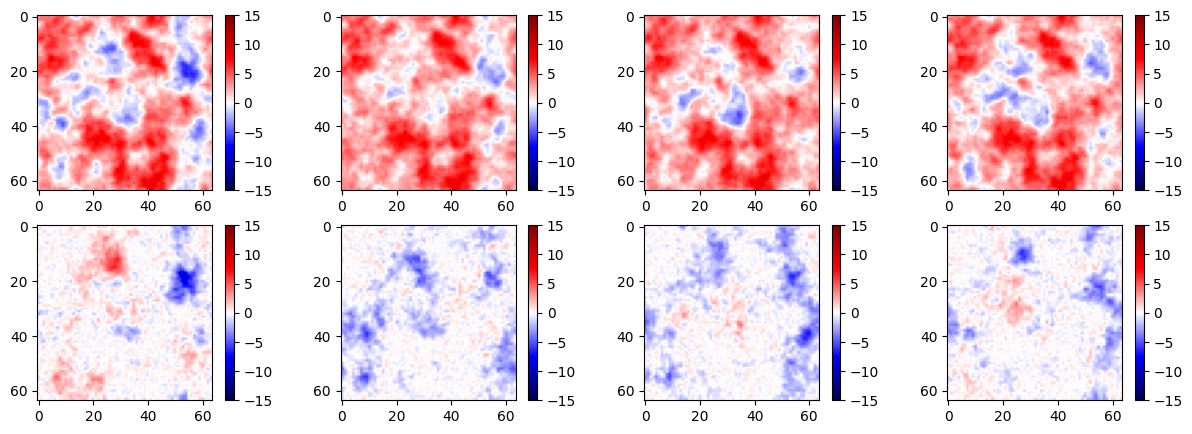

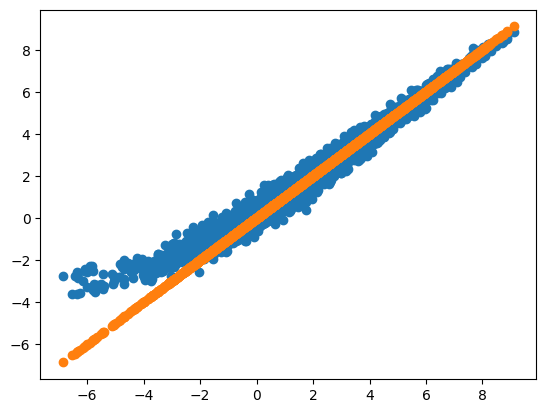

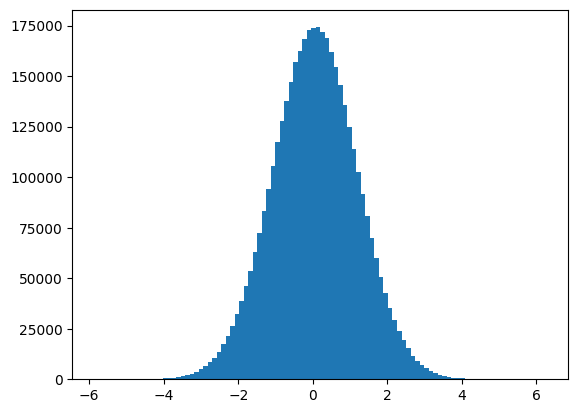

Residual percentiles: [-2.18792056 -1.07064995  0.06227256  1.18540941  2.27547661]


100%|███████████████████████████████████████| 100/100 [00:00<00:00, 1819.88it/s]


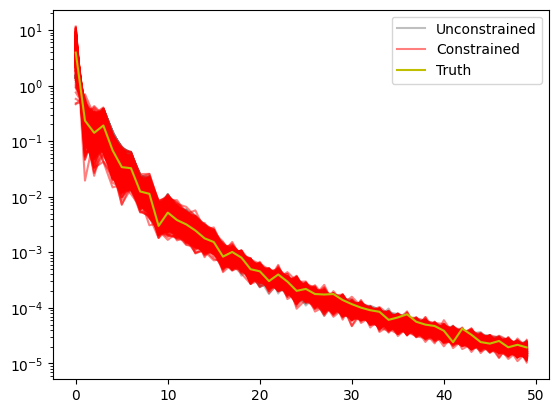

In [13]:
# Estimate delta from free x - round 4
sim, samples = get_samples(n_sims = 1000, bounds = bounds_delta_x, bounds_theta = bounds_theta_x)
trained_delta_x = train_delta_x(samples, max_epochs = 100)
bounds_delta_x = infer_delta_x(sample0, sim, *trained_delta_x, n_draws = 1000, gamma = 0.1)

100%|█████████████████████████████████████| 1000/1000 [00:00<00:00, 1823.64it/s]
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name  | Type                                                     | Params
-----------------------------------------------------------------------------------
0 | lre   | LogRatioEstimator_Gaussian_Autoregressive_X_module_based | 0     
1 | unet  | UNet                                                     | 1.9 M 
2 | norm1 | LazyBatchNorm2d                                          | 0     
-----------------------------------------------------------------------------------
1.9 M     Trainable params
0         Non-trainable params
1.9 M     Total params
7.769     Total estimated model params size (MB)


Epoch 0:  87%|██████▉ | 13/15 [00:00<00:00, 19.80it/s, loss=-1.53e+03, v_num=70]
Validation: 0it [00:00, ?it/s]
Epoch 0:  93%|███████▍| 14/15 [00:00<00:00, 20.02it/s, loss=-1.53e+03, v_num=70]
Epoch 0: 100%|█| 15/15 [00:00<00:00, 20.69it/s, loss=-1.53e+03, v_num=70, val_lo
                                                                                

Metric val_loss improved. New best score: -3685.744


Epoch 1:  87%|▊| 13/15 [00:00<00:00, 18.71it/s, loss=-3.66e+03, v_num=70, val_lo
Validation: 0it [00:00, ?it/s]
Validation DataLoader 0:   0%|                            | 0/2 [00:00<?, ?it/s]
Epoch 1:  93%|▉| 14/15 [00:00<00:00, 18.81it/s, loss=-3.66e+03, v_num=70, val_lo
Epoch 1: 100%|█| 15/15 [00:00<00:00, 19.44it/s, loss=-3.66e+03, v_num=70, val_lo
                                                                                

Metric val_loss improved by 223.675 >= min_delta = 0.0. New best score: -3909.419


Epoch 2:  87%|▊| 13/15 [00:00<00:00, 20.11it/s, loss=-3.9e+03, v_num=70, val_los
Validation: 0it [00:00, ?it/s]
Validation DataLoader 0:   0%|                            | 0/2 [00:00<?, ?it/s]
Epoch 2:  93%|▉| 14/15 [00:00<00:00, 20.43it/s, loss=-3.9e+03, v_num=70, val_los
Epoch 2: 100%|█| 15/15 [00:00<00:00, 21.05it/s, loss=-3.9e+03, v_num=70, val_los
                                                                                

Metric val_loss improved by 143.671 >= min_delta = 0.0. New best score: -4053.090


Epoch 3:  87%|▊| 13/15 [00:00<00:00, 17.12it/s, loss=-4e+03, v_num=70, val_loss=
Validation: 0it [00:00, ?it/s]
Validation DataLoader 0:   0%|                            | 0/2 [00:00<?, ?it/s]
Epoch 3:  93%|▉| 14/15 [00:00<00:00, 17.43it/s, loss=-4e+03, v_num=70, val_loss=
Epoch 3: 100%|█| 15/15 [00:00<00:00, 17.70it/s, loss=-4e+03, v_num=70, val_loss=
                                                                                

Metric val_loss improved by 75.267 >= min_delta = 0.0. New best score: -4128.357


Epoch 4:  87%|▊| 13/15 [00:00<00:00, 19.68it/s, loss=-4.09e+03, v_num=70, val_lo
Validation: 0it [00:00, ?it/s]
Validation DataLoader 0:   0%|                            | 0/2 [00:00<?, ?it/s]
Epoch 4:  93%|▉| 14/15 [00:00<00:00, 19.90it/s, loss=-4.09e+03, v_num=70, val_lo
Epoch 4: 100%|█| 15/15 [00:00<00:00, 19.91it/s, loss=-4.09e+03, v_num=70, val_lo
                                                                                

Metric val_loss improved by 50.510 >= min_delta = 0.0. New best score: -4178.867


Epoch 5:  87%|▊| 13/15 [00:00<00:00, 16.21it/s, loss=-4.16e+03, v_num=70, val_lo
Validation: 0it [00:00, ?it/s]
Validation DataLoader 0:   0%|                            | 0/2 [00:00<?, ?it/s]
Epoch 5:  93%|▉| 14/15 [00:00<00:00, 16.42it/s, loss=-4.16e+03, v_num=70, val_lo
Epoch 5: 100%|█| 15/15 [00:00<00:00, 16.65it/s, loss=-4.16e+03, v_num=70, val_lo
                                                                                

Metric val_loss improved by 63.367 >= min_delta = 0.0. New best score: -4242.234


Epoch 6:  87%|▊| 13/15 [00:00<00:00, 16.98it/s, loss=-4.22e+03, v_num=70, val_lo
Validation: 0it [00:00, ?it/s]
Validation DataLoader 0:   0%|                            | 0/2 [00:00<?, ?it/s]
Epoch 6:  93%|▉| 14/15 [00:00<00:00, 16.87it/s, loss=-4.22e+03, v_num=70, val_lo
Epoch 6: 100%|█| 15/15 [00:00<00:00, 17.10it/s, loss=-4.22e+03, v_num=70, val_lo
                                                                                

Metric val_loss improved by 50.836 >= min_delta = 0.0. New best score: -4293.070


Epoch 7:  87%|▊| 13/15 [00:00<00:00, 15.18it/s, loss=-4.27e+03, v_num=70, val_lo
Validation: 0it [00:00, ?it/s]
Validation DataLoader 0:   0%|                            | 0/2 [00:00<?, ?it/s]
Epoch 7:  93%|▉| 14/15 [00:00<00:00, 15.56it/s, loss=-4.27e+03, v_num=70, val_lo
Epoch 7: 100%|█| 15/15 [00:00<00:00, 16.19it/s, loss=-4.27e+03, v_num=70, val_lo
                                                                                

Metric val_loss improved by 20.718 >= min_delta = 0.0. New best score: -4313.788


Epoch 8:  87%|▊| 13/15 [00:00<00:00, 17.99it/s, loss=-4.31e+03, v_num=70, val_lo
Validation: 0it [00:00, ?it/s]
Validation DataLoader 0:   0%|                            | 0/2 [00:00<?, ?it/s]
Epoch 8:  93%|▉| 14/15 [00:00<00:00, 18.19it/s, loss=-4.31e+03, v_num=70, val_lo
Epoch 8: 100%|█| 15/15 [00:00<00:00, 18.53it/s, loss=-4.31e+03, v_num=70, val_lo
                                                                                

Metric val_loss improved by 15.406 >= min_delta = 0.0. New best score: -4329.194


Epoch 9:  87%|▊| 13/15 [00:00<00:00, 18.11it/s, loss=-4.34e+03, v_num=70, val_lo
Validation: 0it [00:00, ?it/s]
Validation DataLoader 0:   0%|                            | 0/2 [00:00<?, ?it/s]
Epoch 9:  93%|▉| 14/15 [00:00<00:00, 17.89it/s, loss=-4.34e+03, v_num=70, val_lo
Epoch 9: 100%|█| 15/15 [00:00<00:00, 18.14it/s, loss=-4.34e+03, v_num=70, val_lo
                                                                                

Metric val_loss improved by 0.346 >= min_delta = 0.0. New best score: -4329.539


Epoch 10:  87%|▊| 13/15 [00:00<00:00, 17.16it/s, loss=-4.36e+03, v_num=70, val_l
Validation: 0it [00:00, ?it/s]
Validation DataLoader 0:   0%|                            | 0/2 [00:00<?, ?it/s]
Epoch 10:  93%|▉| 14/15 [00:00<00:00, 16.98it/s, loss=-4.36e+03, v_num=70, val_l
Epoch 10: 100%|█| 15/15 [00:00<00:00, 17.19it/s, loss=-4.36e+03, v_num=70, val_l
Epoch 11:  87%|▊| 13/15 [00:00<00:00, 15.60it/s, loss=-4.38e+03, v_num=70, val_l
Validation: 0it [00:00, ?it/s]
Validation DataLoader 0:   0%|                            | 0/2 [00:00<?, ?it/s]
Epoch 11:  93%|▉| 14/15 [00:00<00:00, 15.91it/s, loss=-4.38e+03, v_num=70, val_l
Epoch 11: 100%|█| 15/15 [00:00<00:00, 16.20it/s, loss=-4.38e+03, v_num=70, val_l
Epoch 12:  87%|▊| 13/15 [00:00<00:00, 16.77it/s, loss=-4.39e+03, v_num=70, val_l
Validation: 0it [00:00, ?it/s]
Validation DataLoader 0:   0%|                            | 0/2 [00:00<?, ?it/s]
Epoch 12:  93%|▉| 14/15 [00:00<00:00, 16.84it/s, loss=-4.39e+03, v_num=70, val_l
Epoch 12: 100%|█

Metric val_loss improved by 3.371 >= min_delta = 0.0. New best score: -4332.911


Epoch 14:  87%|▊| 13/15 [00:00<00:00, 15.41it/s, loss=-4.42e+03, v_num=70, val_l
Validation: 0it [00:00, ?it/s]
Validation DataLoader 0:   0%|                            | 0/2 [00:00<?, ?it/s]
Epoch 14:  93%|▉| 14/15 [00:00<00:00, 15.65it/s, loss=-4.42e+03, v_num=70, val_l
Epoch 14: 100%|█| 15/15 [00:00<00:00, 16.26it/s, loss=-4.42e+03, v_num=70, val_l
                                                                                

Metric val_loss improved by 15.847 >= min_delta = 0.0. New best score: -4348.758


Epoch 15:  87%|▊| 13/15 [00:00<00:00, 16.06it/s, loss=-4.43e+03, v_num=70, val_l
Validation: 0it [00:00, ?it/s]
Validation DataLoader 0:   0%|                            | 0/2 [00:00<?, ?it/s]
Epoch 15:  93%|▉| 14/15 [00:00<00:00, 16.18it/s, loss=-4.43e+03, v_num=70, val_l
Epoch 15: 100%|█| 15/15 [00:00<00:00, 16.74it/s, loss=-4.43e+03, v_num=70, val_l
                                                                                

Metric val_loss improved by 12.046 >= min_delta = 0.0. New best score: -4360.803


Epoch 16:  87%|▊| 13/15 [00:00<00:00, 17.55it/s, loss=-4.44e+03, v_num=70, val_l
Validation: 0it [00:00, ?it/s]
Validation DataLoader 0:   0%|                            | 0/2 [00:00<?, ?it/s]
Epoch 16:  93%|▉| 14/15 [00:00<00:00, 17.64it/s, loss=-4.44e+03, v_num=70, val_l
Epoch 16: 100%|█| 15/15 [00:00<00:00, 18.25it/s, loss=-4.44e+03, v_num=70, val_l
                                                                                

Metric val_loss improved by 20.394 >= min_delta = 0.0. New best score: -4381.198


Epoch 17:  87%|▊| 13/15 [00:00<00:00, 17.99it/s, loss=-4.45e+03, v_num=70, val_l
Validation: 0it [00:00, ?it/s]
Validation DataLoader 0:   0%|                            | 0/2 [00:00<?, ?it/s]
Epoch 17:  93%|▉| 14/15 [00:00<00:00, 17.96it/s, loss=-4.45e+03, v_num=70, val_l
Epoch 17: 100%|█| 15/15 [00:00<00:00, 18.25it/s, loss=-4.45e+03, v_num=70, val_l
                                                                                

Metric val_loss improved by 9.840 >= min_delta = 0.0. New best score: -4391.038


Epoch 18:  87%|▊| 13/15 [00:00<00:00, 14.99it/s, loss=-4.46e+03, v_num=70, val_l
Validation: 0it [00:00, ?it/s]
Validation DataLoader 0:   0%|                            | 0/2 [00:00<?, ?it/s]
Epoch 18:  93%|▉| 14/15 [00:00<00:00, 15.33it/s, loss=-4.46e+03, v_num=70, val_l
Epoch 18: 100%|█| 15/15 [00:00<00:00, 15.95it/s, loss=-4.46e+03, v_num=70, val_l
                                                                                

Metric val_loss improved by 34.314 >= min_delta = 0.0. New best score: -4425.352


Epoch 19:  87%|▊| 13/15 [00:00<00:00, 18.30it/s, loss=-4.46e+03, v_num=70, val_l
Validation: 0it [00:00, ?it/s]
Validation DataLoader 0:   0%|                            | 0/2 [00:00<?, ?it/s]
Epoch 19:  93%|▉| 14/15 [00:00<00:00, 18.30it/s, loss=-4.46e+03, v_num=70, val_l
Epoch 19: 100%|█| 15/15 [00:00<00:00, 18.91it/s, loss=-4.46e+03, v_num=70, val_l
Epoch 20:  87%|▊| 13/15 [00:00<00:00, 16.16it/s, loss=-4.47e+03, v_num=70, val_l
Validation: 0it [00:00, ?it/s]
Validation DataLoader 0:   0%|                            | 0/2 [00:00<?, ?it/s]
Epoch 20:  93%|▉| 14/15 [00:00<00:00, 16.33it/s, loss=-4.47e+03, v_num=70, val_l
Epoch 20: 100%|█| 15/15 [00:00<00:00, 16.40it/s, loss=-4.47e+03, v_num=70, val_l
Epoch 21:  87%|▊| 13/15 [00:00<00:00, 18.16it/s, loss=-4.47e+03, v_num=70, val_l
Validation: 0it [00:00, ?it/s]
Validation DataLoader 0:   0%|                            | 0/2 [00:00<?, ?it/s]
Epoch 21:  93%|▉| 14/15 [00:00<00:00, 18.29it/s, loss=-4.47e+03, v_num=70, val_l
Epoch 21: 100%|█

Metric val_loss improved by 70.388 >= min_delta = 0.0. New best score: -4495.739


Epoch 24:  87%|▊| 13/15 [00:00<00:00, 16.34it/s, loss=-4.5e+03, v_num=70, val_lo
Validation: 0it [00:00, ?it/s]
Validation DataLoader 0:   0%|                            | 0/2 [00:00<?, ?it/s]
Epoch 24:  93%|▉| 14/15 [00:00<00:00, 16.09it/s, loss=-4.5e+03, v_num=70, val_lo
Epoch 24: 100%|█| 15/15 [00:00<00:00, 16.38it/s, loss=-4.5e+03, v_num=70, val_lo
                                                                                

Metric val_loss improved by 21.701 >= min_delta = 0.0. New best score: -4517.441


Epoch 25:  87%|▊| 13/15 [00:00<00:00, 16.77it/s, loss=-4.51e+03, v_num=70, val_l
Validation: 0it [00:00, ?it/s]
Validation DataLoader 0:   0%|                            | 0/2 [00:00<?, ?it/s]
Epoch 25:  93%|▉| 14/15 [00:00<00:00, 16.69it/s, loss=-4.51e+03, v_num=70, val_l
Epoch 25: 100%|█| 15/15 [00:00<00:00, 16.73it/s, loss=-4.51e+03, v_num=70, val_l
Epoch 26:  87%|▊| 13/15 [00:00<00:00, 18.78it/s, loss=-4.51e+03, v_num=70, val_l
Validation: 0it [00:00, ?it/s]
Validation DataLoader 0:   0%|                            | 0/2 [00:00<?, ?it/s]
Epoch 26:  93%|▉| 14/15 [00:00<00:00, 18.54it/s, loss=-4.51e+03, v_num=70, val_l
Epoch 26: 100%|█| 15/15 [00:00<00:00, 18.83it/s, loss=-4.51e+03, v_num=70, val_l
Epoch 27:  87%|▊| 13/15 [00:00<00:00, 18.08it/s, loss=-4.52e+03, v_num=70, val_l
Validation: 0it [00:00, ?it/s]
Validation DataLoader 0:   0%|                            | 0/2 [00:00<?, ?it/s]
Epoch 27:  93%|▉| 14/15 [00:00<00:00, 18.22it/s, loss=-4.52e+03, v_num=70, val_l
Epoch 27: 100%|█

Monitored metric val_loss did not improve in the last 10 records. Best score: -4517.441. Signaling Trainer to stop.


Epoch 34: 100%|█| 15/15 [00:00<00:00, 19.51it/s, loss=-4.53e+03, v_num=70, val_l


Restoring states from the checkpoint path at /home/cweniger/swyft/notebooks/dev/lightning_logs/version_70/checkpoints/rongs_epoch=24_val_loss=-4517.44_train_loss=-4498.14.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from checkpoint at /home/cweniger/swyft/notebooks/dev/lightning_logs/version_70/checkpoints/rongs_epoch=24_val_loss=-4517.44_train_loss=-4498.14.ckpt


Testing DataLoader 0: 100%|███████████████████████| 2/2 [00:00<00:00, 41.08it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           -4581.410128444006
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


100%|███████████████████████████████████████| 1000/1000 [02:00<00:00,  8.27it/s]


0.029589355 6.047198 -7.901484786456242 8.97255724324613


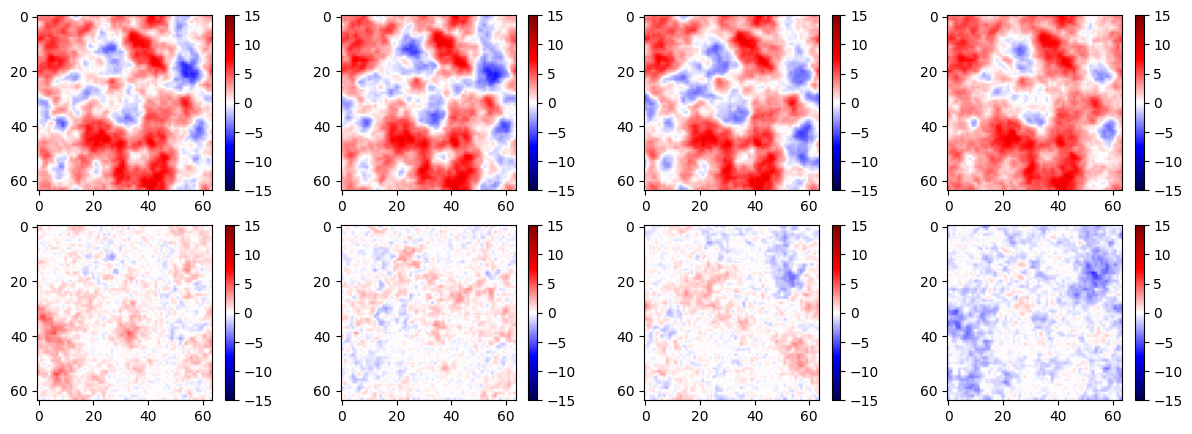

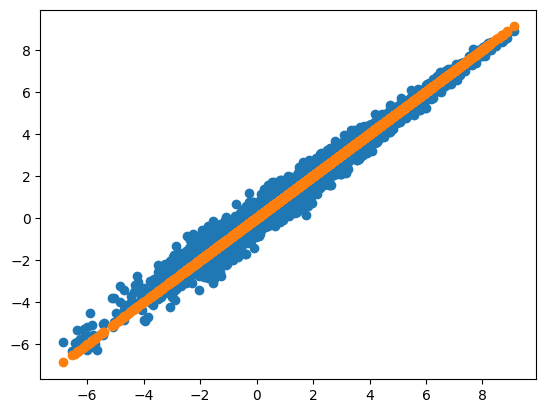

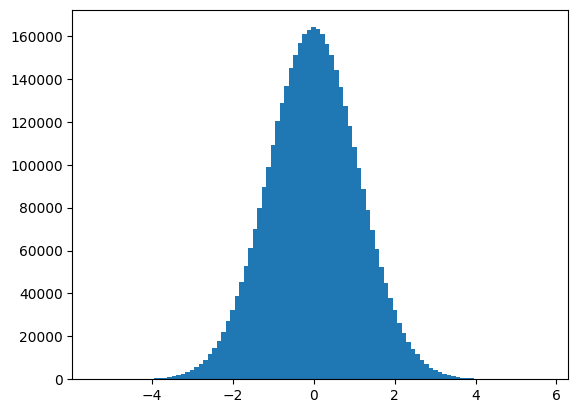

Residual percentiles: [-2.188843   -1.11242831 -0.00723008  1.09912369  2.17715422]


100%|███████████████████████████████████████| 100/100 [00:00<00:00, 1848.97it/s]


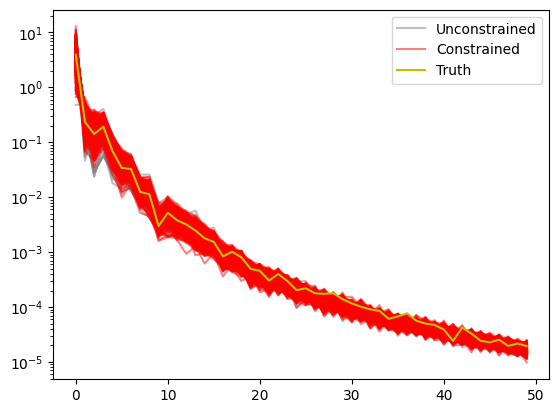

In [14]:
# Estimate delta from free x - round 4
sim, samples = get_samples(n_sims = 1000, bounds = bounds_delta_x, bounds_theta = bounds_theta_x)
trained_delta_x = train_delta_x(samples, max_epochs = 100)
bounds_delta_x = infer_delta_x(sample0, sim, *trained_delta_x, n_draws = 1000, gamma = 0.1)

100%|█████████████████████████████████████| 1000/1000 [00:00<00:00, 1831.69it/s]
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name  | Type                                                     | Params
-----------------------------------------------------------------------------------
0 | lre   | LogRatioEstimator_Gaussian_Autoregressive_X_module_based | 0     
1 | unet  | UNet                                                     | 1.9 M 
2 | norm1 | LazyBatchNorm2d                                          | 0     
-----------------------------------------------------------------------------------
1.9 M     Trainable params
0         Non-trainable params
1.9 M     Total params
7.769     Total estimated model params size (MB)


Epoch 0:  87%|███████████▎ | 13/15 [00:00<00:00, 18.86it/s, loss=-247, v_num=71]
Validation: 0it [00:00, ?it/s]
Epoch 0:  93%|████████████▏| 14/15 [00:00<00:00, 18.82it/s, loss=-247, v_num=71]
Epoch 0: 100%|█| 15/15 [00:00<00:00, 18.86it/s, loss=-247, v_num=71, val_loss=-3
                                                                                

Metric val_loss improved. New best score: -3693.336


Epoch 1:  87%|▊| 13/15 [00:00<00:00, 18.75it/s, loss=-3.45e+03, v_num=71, val_lo
Validation: 0it [00:00, ?it/s]
Validation DataLoader 0:   0%|                            | 0/2 [00:00<?, ?it/s]
Epoch 1:  93%|▉| 14/15 [00:00<00:00, 18.98it/s, loss=-3.45e+03, v_num=71, val_lo
Epoch 1: 100%|█| 15/15 [00:00<00:00, 19.67it/s, loss=-3.45e+03, v_num=71, val_lo
                                                                                

Metric val_loss improved by 111.004 >= min_delta = 0.0. New best score: -3804.340


Epoch 2:  87%|▊| 13/15 [00:00<00:00, 18.09it/s, loss=-3.78e+03, v_num=71, val_lo
Validation: 0it [00:00, ?it/s]
Validation DataLoader 0:   0%|                            | 0/2 [00:00<?, ?it/s]
Epoch 2:  93%|▉| 14/15 [00:00<00:00, 18.08it/s, loss=-3.78e+03, v_num=71, val_lo
Epoch 2: 100%|█| 15/15 [00:00<00:00, 18.71it/s, loss=-3.78e+03, v_num=71, val_lo
                                                                                

Metric val_loss improved by 187.011 >= min_delta = 0.0. New best score: -3991.351


Epoch 3:  87%|▊| 13/15 [00:00<00:00, 16.72it/s, loss=-3.91e+03, v_num=71, val_lo
Validation: 0it [00:00, ?it/s]
Validation DataLoader 0:   0%|                            | 0/2 [00:00<?, ?it/s]
Epoch 3:  93%|▉| 14/15 [00:00<00:00, 16.73it/s, loss=-3.91e+03, v_num=71, val_lo
Epoch 3: 100%|█| 15/15 [00:00<00:00, 17.33it/s, loss=-3.91e+03, v_num=71, val_lo
                                                                                

Metric val_loss improved by 98.698 >= min_delta = 0.0. New best score: -4090.049


Epoch 4:  87%|▊| 13/15 [00:00<00:00, 19.32it/s, loss=-4.02e+03, v_num=71, val_lo
Validation: 0it [00:00, ?it/s]
Validation DataLoader 0:   0%|                            | 0/2 [00:00<?, ?it/s]
Epoch 4:  93%|▉| 14/15 [00:00<00:00, 19.52it/s, loss=-4.02e+03, v_num=71, val_lo
Epoch 4: 100%|█| 15/15 [00:00<00:00, 19.71it/s, loss=-4.02e+03, v_num=71, val_lo
                                                                                

Metric val_loss improved by 90.659 >= min_delta = 0.0. New best score: -4180.708


Epoch 5:  87%|▊| 13/15 [00:00<00:00, 18.79it/s, loss=-4.12e+03, v_num=71, val_lo
Validation: 0it [00:00, ?it/s]
Validation DataLoader 0:   0%|                            | 0/2 [00:00<?, ?it/s]
Epoch 5:  93%|▉| 14/15 [00:00<00:00, 19.02it/s, loss=-4.12e+03, v_num=71, val_lo
Epoch 5: 100%|█| 15/15 [00:00<00:00, 19.69it/s, loss=-4.12e+03, v_num=71, val_lo
                                                                                

Metric val_loss improved by 66.442 >= min_delta = 0.0. New best score: -4247.150


Epoch 6:  87%|▊| 13/15 [00:00<00:00, 18.46it/s, loss=-4.19e+03, v_num=71, val_lo
Validation: 0it [00:00, ?it/s]
Validation DataLoader 0:   0%|                            | 0/2 [00:00<?, ?it/s]
Epoch 6:  93%|▉| 14/15 [00:00<00:00, 18.57it/s, loss=-4.19e+03, v_num=71, val_lo
Epoch 6: 100%|█| 15/15 [00:00<00:00, 18.63it/s, loss=-4.19e+03, v_num=71, val_lo
                                                                                

Metric val_loss improved by 39.002 >= min_delta = 0.0. New best score: -4286.153


Epoch 7:  87%|▊| 13/15 [00:00<00:00, 16.50it/s, loss=-4.25e+03, v_num=71, val_lo
Validation: 0it [00:00, ?it/s]
Validation DataLoader 0:   0%|                            | 0/2 [00:00<?, ?it/s]
Epoch 7:  93%|▉| 14/15 [00:00<00:00, 16.60it/s, loss=-4.25e+03, v_num=71, val_lo
Epoch 7: 100%|█| 15/15 [00:00<00:00, 16.84it/s, loss=-4.25e+03, v_num=71, val_lo
                                                                                

Metric val_loss improved by 38.543 >= min_delta = 0.0. New best score: -4324.696


Epoch 8:  87%|▊| 13/15 [00:00<00:00, 17.20it/s, loss=-4.29e+03, v_num=71, val_lo
Validation: 0it [00:00, ?it/s]
Validation DataLoader 0:   0%|                            | 0/2 [00:00<?, ?it/s]
Epoch 8:  93%|▉| 14/15 [00:00<00:00, 17.40it/s, loss=-4.29e+03, v_num=71, val_lo
Epoch 8: 100%|█| 15/15 [00:00<00:00, 17.67it/s, loss=-4.29e+03, v_num=71, val_lo
                                                                                

Metric val_loss improved by 33.068 >= min_delta = 0.0. New best score: -4357.763


Epoch 9:  87%|▊| 13/15 [00:00<00:00, 14.93it/s, loss=-4.32e+03, v_num=71, val_lo
Validation: 0it [00:00, ?it/s]
Validation DataLoader 0:   0%|                            | 0/2 [00:00<?, ?it/s]
Epoch 9:  93%|▉| 14/15 [00:00<00:00, 14.97it/s, loss=-4.32e+03, v_num=71, val_lo
Epoch 9: 100%|█| 15/15 [00:00<00:00, 15.50it/s, loss=-4.32e+03, v_num=71, val_lo
                                                                                

Metric val_loss improved by 32.355 >= min_delta = 0.0. New best score: -4390.118


Epoch 10:  87%|▊| 13/15 [00:00<00:00, 18.90it/s, loss=-4.35e+03, v_num=71, val_l
Validation: 0it [00:00, ?it/s]
Validation DataLoader 0:   0%|                            | 0/2 [00:00<?, ?it/s]
Epoch 10:  93%|▉| 14/15 [00:00<00:00, 19.29it/s, loss=-4.35e+03, v_num=71, val_l
Epoch 10: 100%|█| 15/15 [00:00<00:00, 19.97it/s, loss=-4.35e+03, v_num=71, val_l
                                                                                

Metric val_loss improved by 24.308 >= min_delta = 0.0. New best score: -4414.426


Epoch 11:  87%|▊| 13/15 [00:00<00:00, 19.51it/s, loss=-4.37e+03, v_num=71, val_l
Validation: 0it [00:00, ?it/s]
Validation DataLoader 0:   0%|                            | 0/2 [00:00<?, ?it/s]
Epoch 11:  93%|▉| 14/15 [00:00<00:00, 19.52it/s, loss=-4.37e+03, v_num=71, val_l
Epoch 11: 100%|█| 15/15 [00:00<00:00, 20.19it/s, loss=-4.37e+03, v_num=71, val_l
                                                                                

Metric val_loss improved by 13.500 >= min_delta = 0.0. New best score: -4427.926


Epoch 12:  87%|▊| 13/15 [00:00<00:00, 20.12it/s, loss=-4.39e+03, v_num=71, val_l
Validation: 0it [00:00, ?it/s]
Validation DataLoader 0:   0%|                            | 0/2 [00:00<?, ?it/s]
Epoch 12:  93%|▉| 14/15 [00:00<00:00, 20.31it/s, loss=-4.39e+03, v_num=71, val_l
Epoch 12: 100%|█| 15/15 [00:00<00:00, 20.64it/s, loss=-4.39e+03, v_num=71, val_l
                                                                                

Metric val_loss improved by 16.799 >= min_delta = 0.0. New best score: -4444.725


Epoch 13:  87%|▊| 13/15 [00:00<00:00, 18.99it/s, loss=-4.4e+03, v_num=71, val_lo
Validation: 0it [00:00, ?it/s]
Validation DataLoader 0:   0%|                            | 0/2 [00:00<?, ?it/s]
Epoch 13:  93%|▉| 14/15 [00:00<00:00, 19.19it/s, loss=-4.4e+03, v_num=71, val_lo
Epoch 13: 100%|█| 15/15 [00:00<00:00, 19.85it/s, loss=-4.4e+03, v_num=71, val_lo
                                                                                

Metric val_loss improved by 14.388 >= min_delta = 0.0. New best score: -4459.113


Epoch 14:  87%|▊| 13/15 [00:00<00:00, 19.67it/s, loss=-4.41e+03, v_num=71, val_l
Validation: 0it [00:00, ?it/s]
Validation DataLoader 0:   0%|                            | 0/2 [00:00<?, ?it/s]
Epoch 14:  93%|▉| 14/15 [00:00<00:00, 19.71it/s, loss=-4.41e+03, v_num=71, val_l
Epoch 14: 100%|█| 15/15 [00:00<00:00, 20.36it/s, loss=-4.41e+03, v_num=71, val_l
                                                                                

Metric val_loss improved by 8.332 >= min_delta = 0.0. New best score: -4467.445


Epoch 15:  87%|▊| 13/15 [00:00<00:00, 16.43it/s, loss=-4.43e+03, v_num=71, val_l
Validation: 0it [00:00, ?it/s]
Validation DataLoader 0:   0%|                            | 0/2 [00:00<?, ?it/s]
Epoch 15:  93%|▉| 14/15 [00:00<00:00, 16.71it/s, loss=-4.43e+03, v_num=71, val_l
Epoch 15: 100%|█| 15/15 [00:00<00:00, 17.08it/s, loss=-4.43e+03, v_num=71, val_l
                                                                                

Metric val_loss improved by 13.602 >= min_delta = 0.0. New best score: -4481.047


Epoch 16:  87%|▊| 13/15 [00:00<00:00, 15.78it/s, loss=-4.44e+03, v_num=71, val_l
Validation: 0it [00:00, ?it/s]
Validation DataLoader 0:   0%|                            | 0/2 [00:00<?, ?it/s]
Epoch 16:  93%|▉| 14/15 [00:00<00:00, 16.11it/s, loss=-4.44e+03, v_num=71, val_l
Epoch 16: 100%|█| 15/15 [00:00<00:00, 16.42it/s, loss=-4.44e+03, v_num=71, val_l
                                                                                

Metric val_loss improved by 0.293 >= min_delta = 0.0. New best score: -4481.340


Epoch 17:  87%|▊| 13/15 [00:00<00:00, 16.35it/s, loss=-4.45e+03, v_num=71, val_l
Validation: 0it [00:00, ?it/s]
Validation DataLoader 0:   0%|                            | 0/2 [00:00<?, ?it/s]
Epoch 17:  93%|▉| 14/15 [00:00<00:00, 16.45it/s, loss=-4.45e+03, v_num=71, val_l
Epoch 17: 100%|█| 15/15 [00:00<00:00, 17.00it/s, loss=-4.45e+03, v_num=71, val_l
Epoch 18:  87%|▊| 13/15 [00:00<00:00, 16.16it/s, loss=-4.45e+03, v_num=71, val_l
Validation: 0it [00:00, ?it/s]
Validation DataLoader 0:   0%|                            | 0/2 [00:00<?, ?it/s]
Epoch 18:  93%|▉| 14/15 [00:00<00:00, 16.18it/s, loss=-4.45e+03, v_num=71, val_l
Epoch 18: 100%|█| 15/15 [00:00<00:00, 16.78it/s, loss=-4.45e+03, v_num=71, val_l
Epoch 19:  87%|▊| 13/15 [00:00<00:00, 14.71it/s, loss=-4.46e+03, v_num=71, val_l
Validation: 0it [00:00, ?it/s]
Validation DataLoader 0:   0%|                            | 0/2 [00:00<?, ?it/s]
Epoch 19:  93%|▉| 14/15 [00:00<00:00, 14.83it/s, loss=-4.46e+03, v_num=71, val_l
Epoch 19: 100%|█

Metric val_loss improved by 12.271 >= min_delta = 0.0. New best score: -4493.611


Epoch 20:  87%|▊| 13/15 [00:00<00:00, 16.94it/s, loss=-4.47e+03, v_num=71, val_l
Validation: 0it [00:00, ?it/s]
Validation DataLoader 0:   0%|                            | 0/2 [00:00<?, ?it/s]
Epoch 20:  93%|▉| 14/15 [00:00<00:00, 17.20it/s, loss=-4.47e+03, v_num=71, val_l
Epoch 20: 100%|█| 15/15 [00:00<00:00, 17.49it/s, loss=-4.47e+03, v_num=71, val_l
                                                                                

Metric val_loss improved by 3.716 >= min_delta = 0.0. New best score: -4497.326


Epoch 21:  87%|▊| 13/15 [00:00<00:00, 16.08it/s, loss=-4.48e+03, v_num=71, val_l
Validation: 0it [00:00, ?it/s]
Validation DataLoader 0:   0%|                            | 0/2 [00:00<?, ?it/s]
Epoch 21:  93%|▉| 14/15 [00:00<00:00, 16.06it/s, loss=-4.48e+03, v_num=71, val_l
Epoch 21: 100%|█| 15/15 [00:00<00:00, 16.28it/s, loss=-4.48e+03, v_num=71, val_l
Epoch 22:  87%|▊| 13/15 [00:00<00:00, 17.11it/s, loss=-4.49e+03, v_num=71, val_l
Validation: 0it [00:00, ?it/s]
Validation DataLoader 0:   0%|                            | 0/2 [00:00<?, ?it/s]
Epoch 22:  93%|▉| 14/15 [00:00<00:00, 17.01it/s, loss=-4.49e+03, v_num=71, val_l
Epoch 22: 100%|█| 15/15 [00:00<00:00, 17.57it/s, loss=-4.49e+03, v_num=71, val_l
Epoch 23:  87%|▊| 13/15 [00:00<00:00, 18.09it/s, loss=-4.49e+03, v_num=71, val_l
Validation: 0it [00:00, ?it/s]
Validation DataLoader 0:   0%|                            | 0/2 [00:00<?, ?it/s]
Epoch 23:  93%|▉| 14/15 [00:00<00:00, 18.43it/s, loss=-4.49e+03, v_num=71, val_l
Epoch 23: 100%|█

Metric val_loss improved by 26.199 >= min_delta = 0.0. New best score: -4523.526


Epoch 26:  87%|▊| 13/15 [00:00<00:00, 16.78it/s, loss=-4.53e+03, v_num=71, val_l
Validation: 0it [00:00, ?it/s]
Validation DataLoader 0:   0%|                            | 0/2 [00:00<?, ?it/s]
Epoch 26:  93%|▉| 14/15 [00:00<00:00, 16.84it/s, loss=-4.53e+03, v_num=71, val_l
Epoch 26: 100%|█| 15/15 [00:00<00:00, 17.05it/s, loss=-4.53e+03, v_num=71, val_l
Epoch 27:  87%|▊| 13/15 [00:00<00:00, 14.69it/s, loss=-4.53e+03, v_num=71, val_l
Validation: 0it [00:00, ?it/s]
Validation DataLoader 0:   0%|                            | 0/2 [00:00<?, ?it/s]
Epoch 27:  93%|▉| 14/15 [00:00<00:00, 14.72it/s, loss=-4.53e+03, v_num=71, val_l
Epoch 27: 100%|█| 15/15 [00:00<00:00, 15.22it/s, loss=-4.53e+03, v_num=71, val_l
Epoch 28:  87%|▊| 13/15 [00:00<00:00, 16.05it/s, loss=-4.54e+03, v_num=71, val_l
Validation: 0it [00:00, ?it/s]
Validation DataLoader 0:   0%|                            | 0/2 [00:00<?, ?it/s]
Epoch 28:  93%|▉| 14/15 [00:00<00:00, 16.42it/s, loss=-4.54e+03, v_num=71, val_l
Epoch 28: 100%|█

Monitored metric val_loss did not improve in the last 10 records. Best score: -4523.526. Signaling Trainer to stop.


Epoch 35: 100%|█| 15/15 [00:00<00:00, 19.30it/s, loss=-4.56e+03, v_num=71, val_l


Restoring states from the checkpoint path at /home/cweniger/swyft/notebooks/dev/lightning_logs/version_71/checkpoints/rongs_epoch=25_val_loss=-4523.53_train_loss=-4560.84.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from checkpoint at /home/cweniger/swyft/notebooks/dev/lightning_logs/version_71/checkpoints/rongs_epoch=25_val_loss=-4523.53_train_loss=-4560.84.ckpt


Testing DataLoader 0: 100%|███████████████████████| 2/2 [00:00<00:00, 29.10it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           -4551.837245843513
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


100%|███████████████████████████████████████| 1000/1000 [01:58<00:00,  8.44it/s]


0.029589355 6.047198 -8.36277467056062 9.01573581761808


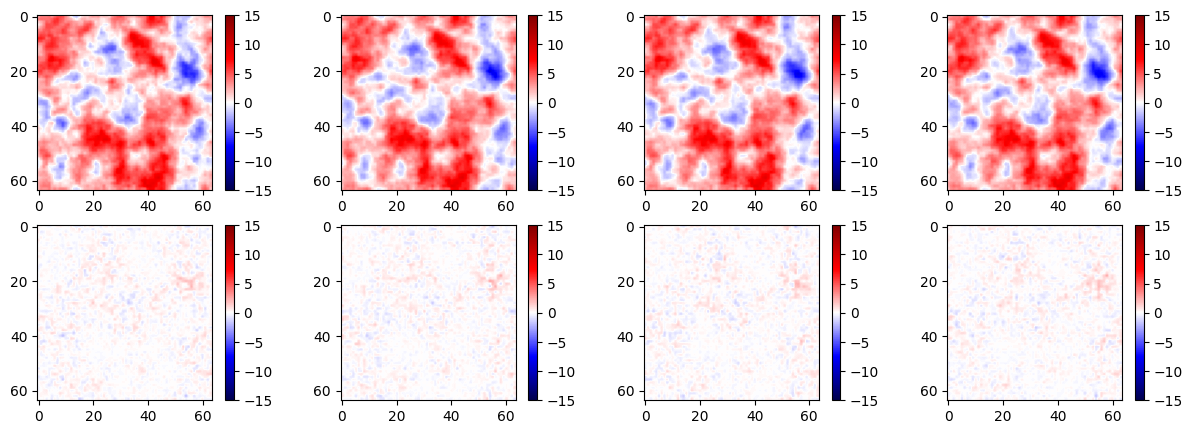

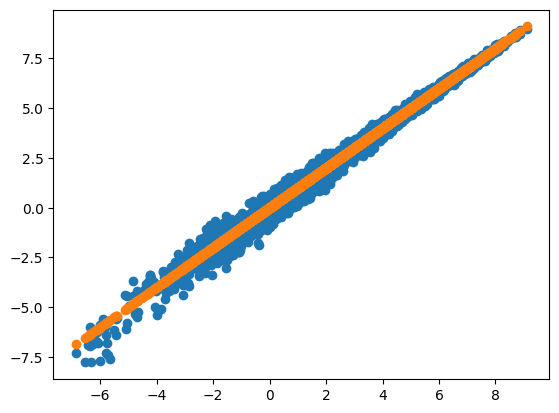

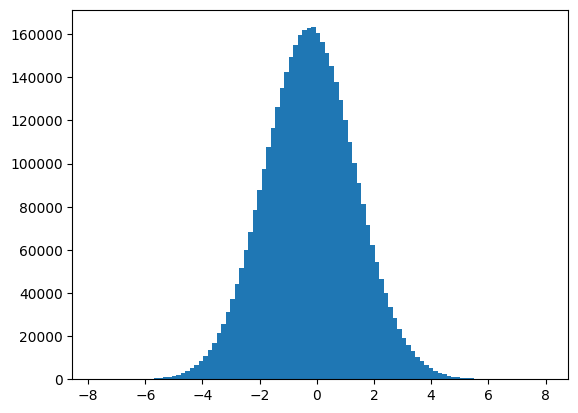

Residual percentiles: [-3.31169037 -1.80228121 -0.2342579   1.34200546  2.90646642]


100%|███████████████████████████████████████| 100/100 [00:00<00:00, 1846.78it/s]


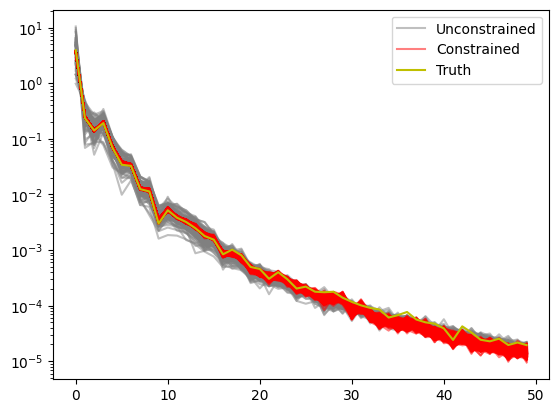

In [15]:
# Estimate delta from free x - round 4
sim, samples = get_samples(n_sims = 1000, bounds = bounds_delta_x, bounds_theta = bounds_theta_x)
trained_delta_x = train_delta_x(samples, max_epochs = 100)
bounds_delta_x = infer_delta_x(sample0, sim, *trained_delta_x, n_draws = 1000, gamma = 1)

In [ ]:
# Estimate theta from constrained delta

In [ ]:
# Estimate theta from constrained x

In [14]:
def round(bounds = None, max_epochs = 5, n_sims = 1000, gamma = 0.1, n_draws = 200, slope = 4.):
    sim = SimulatorBlob(Npix = NPIX, bounds = bounds)
    samples = sim.sample(n_sims, exclude = ['pk_fn'])
    #net.cpu(); net.float()
    dm = swyft.SwyftDataModule(samples, fractions = [0.9, 0.1, 0.0], batch_size = 64)
    net = Network(N = NPIX)
    trainer = swyft.SwyftTrainer(accelerator = "gpu", devices = [0], max_epochs = max_epochs, precision = 32)
    logging.getLogger("lightning.pytorch.accelerators.cuda").setLevel(logging.ERROR)
    trainer.fit(net, dm)
    
    GAMMA = gamma # 0.1 # 0.0001
    
    x = sample0['x']
    d = sample0['delta']
    y = net.cuda().double().embed(torch.tensor(x).cuda().double().unsqueeze(0))[0]
    draws = []
    x0s = []
    for _ in tqdm(range(n_draws)):
        pk = SimulatorBlob(Npix = NPIX).sample()['pk_fn']
        prior = sim.powersampler.get_prior_Q_factors(pk)
        prior = (prior[0], prior[1].cuda(), prior[2])
        x0 = net.lre.get_MAP(y, prior, gamma = GAMMA)
        x0s.append(x0)
        draw = net.lre.get_noise_samples_GEDA(1, prior, steps = 300, reset = True, gamma = GAMMA)[0]
        draws.append(draw)
    draws = torch.stack(draws)
    x0s = torch.stack(x0s)
    
    bounds = [(x0s[i].view(NPIX, NPIX).cpu().detach() + draws[i].view(NPIX, NPIX).cpu()).numpy() for i in range(len(draws))]
    bounds = np.array(bounds)

    net.float()
    
    v = 15
    plt.figure(figsize = (15, 5))
    for i in range(4):
        plt.subplot(2, 4, i+1)
        if i == 0:
            plt.imshow(sample0['delta'], cmap = 'seismic', vmin = -v, vmax = v)
        else:
            plt.imshow(bounds[i], vmin = -v, vmax = v, cmap = 'seismic')
        plt.colorbar()    
    #res = [(x0.view(NPIX, NPIX).cpu().detach()*0 + draws[i].view(NPIX, NPIX).cpu()).numpy() for i in range(len(draws))]
    print(x.min(), x.max(), bounds[0].min(), bounds[0].max())
    res = [d - bounds[i] for i in range(len(draws))]
    for i in range(4):
        plt.subplot(2, 4, i+1+4)
        plt.imshow(res[i], vmin = -v, vmax = v, cmap = 'seismic')
        plt.colorbar()
    plt.show()

    x = sample0['delta'].flatten()
    y = bounds.reshape(-1, NPIX**2)
    ym = y.mean(axis=0)
    ys = y.std(axis=0)
    plt.scatter(x, ym)
    plt.scatter(x, x)
    plt.show()

    diff = ((y-x)/ys).flatten()
    plt.hist(diff, bins = 100)
    plt.show()
    p = np.percentile(diff, [2.5, 16, 50, 84, 97.5])
    print("Residual percentiles:", p)

    pks = swyft.utils.get_pk(torch.tensor(bounds))
    clean_sims = SimulatorBlob().sample(100)['delta']
    pks2 = swyft.utils.get_pk(torch.tensor(clean_sims))
    pks3 = swyft.utils.get_pk(torch.tensor(sample0['delta']))
    plt.plot([], '0.5', alpha = 0.5, label = "Unconstrained")
    plt.plot([], 'r', alpha = 0.5, label = "Constrained")
    plt.semilogy(pks2.T, '0.5', alpha = 0.5);
    plt.semilogy(pks.T, 'r', alpha = 0.5);
    plt.semilogy(pks3.T, 'y', label = "Truth");
    plt.legend()
    plt.show()

    prior_draws = sim.sample(1000, targets = ["theta"], exclude = ['pk_fn'])
    results = trainer.infer(net, sample0, prior_draws)

    swyft.plot_1d(results, 'theta[0]', smooth = 1)
    plt.show()
    swyft.plot_1d(results, 'theta:delta[0]', smooth = 1)
    plt.title("Constraint from ground truth delta")
    plt.show()

    prior_draws = sim.sample(10000, targets = ["theta"], exclude = ['pk_fn'])
    s = swyft.Samples(dict(delta_unbound = torch.tensor(bounds).float()))
    results = trainer.infer(net, s.get_dataloader(batch_size = 1, repeat = 1), prior_draws.get_dataloader(batch_size = 10000))

    swyft.plot_1d(results, 'theta:delta[0]', smooth = 1)
    plt.title("Constraint from ground bounded delta")
    plt.show()

    return bounds, trainer, net, sim